In [58]:
%load_ext autoreload 
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from copy import copy
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from metric_learn import LMNN

from joblib import Parallel, delayed

from umap import UMAP
from hdbscan import validity_index as DBCV
from hdbscan import HDBSCAN
from clustering_utils import clustering_by_methods, clustering, plot_clustering_scatter
from utils import get_density, coord_to_pix

from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")
%autoreload 2

# see paper for the thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5

PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0

DATA_PRESERVED_THRESHOLD = 0.9

plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

N_CMAP = 256

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [59]:
CPT = 0.01 # minimal percentage of the data in single cluster
DATA_SPECIFICATION = '' #'_pat0.7'

clustering_results_root = f'results/clustering_cpt-{CPT}{DATA_SPECIFICATION}' + '_small_datasets'

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

In [60]:
datasets_names = ['Sanger', 'Illumina', 'Pyroseq']
tax_names = ['g']

# datasets_names = ['AGP', 'HMP']
# tax_names = ['o', 'f', 'g']

data_orig = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
    
data_pca = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')
        
try:
    data_embeddings = defaultdict(dict)
    embeddings_path = f'./results/embeddings{DATA_SPECIFICATION}'

    for emb_path in glob.glob(embeddings_path + '/*'):
        label_info = emb_path.split('/')[-1].split('.')[0]
        dataset, tax, embedding_type = label_info.split('_')
        d = np.load(emb_path, allow_pickle=True).item()
        label = dataset + '_' + tax
        data_embeddings[embedding_type][label] = d['Z_']
except Exception as e:
    print(e)
    pass
    
distance_root = f'distances_processed{DATA_SPECIFICATION}'
distances_names = ['L1', 'L2', 'JS', 'BC']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 445.81it/s]


In [61]:
clustering_results_root

'results/clustering_cpt-0.01_small_datasets'

In [62]:
!ls -la results/clustering_cpt-0.01_small_datasets/

total 45396
drwxr-xr-x  2 ibulygin users     4096 апр  7 18:15 .
drwxr-xr-x 18 ibulygin users     4096 апр 11 19:25 ..
-rw-r--r--  1 ibulygin users 11217365 апр  7 16:50 BC_cluster_results.npy
-rw-r--r--  1 ibulygin users 17328346 апр  7 16:48 JS_cluster_results.npy
-rw-r--r--  1 ibulygin users  5452883 апр  7 16:42 L1_cluster_results.npy
-rw-r--r--  1 ibulygin users  9869010 апр  7 16:45 L2_cluster_results.npy
-rw-r--r--  1 ibulygin users  2599904 апр  7 18:15 pca_cluster_results.npy


# Clustering: precomputed distances

In [63]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [64]:
class SpectralClustering_prec:
    def __init__(self, *args, **kwargs):
        self.method = SpectralClustering(*args, **kwargs, affinity='precomputed', random_state=42)
    def fit_predict(self, X):
        '''
        X - pairwise_distance matrix
        '''
        A = np.exp(-self.method.gamma * np.abs(X))
        return self.method.fit_predict(A)

In [130]:
# for k,v in distances_orig.items():
#     for k_,v_ in v.items():
#         plt.figure()
#         plt.imshow(v_)
#         plt.colorbar()
#         plt.title(k + k_)
#         plt.show()

# PAM on JS

In [135]:
from sklearn.metrics import calinski_harabasz_score, rand_score, adjusted_rand_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from utils import entropy
from clustering_utils import prediction_strength_CV_precomputed, davies_bouldin_score_precomputed

In [142]:
results = {}
pam_method_params = {'n_clusters':None,
                    'method':'pam',
                    'metric':'precomputed',
                    'init':'k-medoids++',
                    'random_state':42}

for (label,D) in distances_orig['JS'].items():
    
    results_per_k = {}
    
    k = 3
#     for k in tqdm(range(2,10)):

    pam_method_params_k = pam_method_params.copy()
    pam_method_params_k['n_clusters'] = k


    method = KMedoids(**pam_method_params_k)
    labels = method.fit_predict(D)
    X = data_pca[label]

    results_per_k['labels'] = labels
    results_per_k['CH'] = calinski_harabasz_score(X,labels)
    results_per_k['dbind'] = davies_bouldin_score_precomputed(D, labels)
    results_per_k['silh'] = silhouette_score(D, labels, metric='precomputed')
    results_per_k['dbcv'] = DBCV(D, labels, metric='precomputed', d=data_orig[label].shape[1])
    results_per_k['ps'] = prediction_strength_CV_precomputed(D, method)

    # data mass distribution
    n = len(np.unique(labels))
    cl_dist = np.ones(n)
    for i in range(n):
        cl_dist[i] = sum(labels == i)/len(labels)

    results_per_k['entropy'] = entropy(cl_dist)
    
    results[label] = results_per_k

In [147]:
pd.DataFrame(results).T[['dbind', 'silh', 'dbcv', 'ps', 'entropy']]

dbind      silh      dbcv        ps   entropy
Sanger_g    1.426822  0.143162 -0.091963  0.578571  0.994924
Illumina_g  1.765568  0.160252 -0.317725  0.395238  1.055102
Pyroseq_g   1.579279  0.216448   -0.2729  0.437302  0.898864

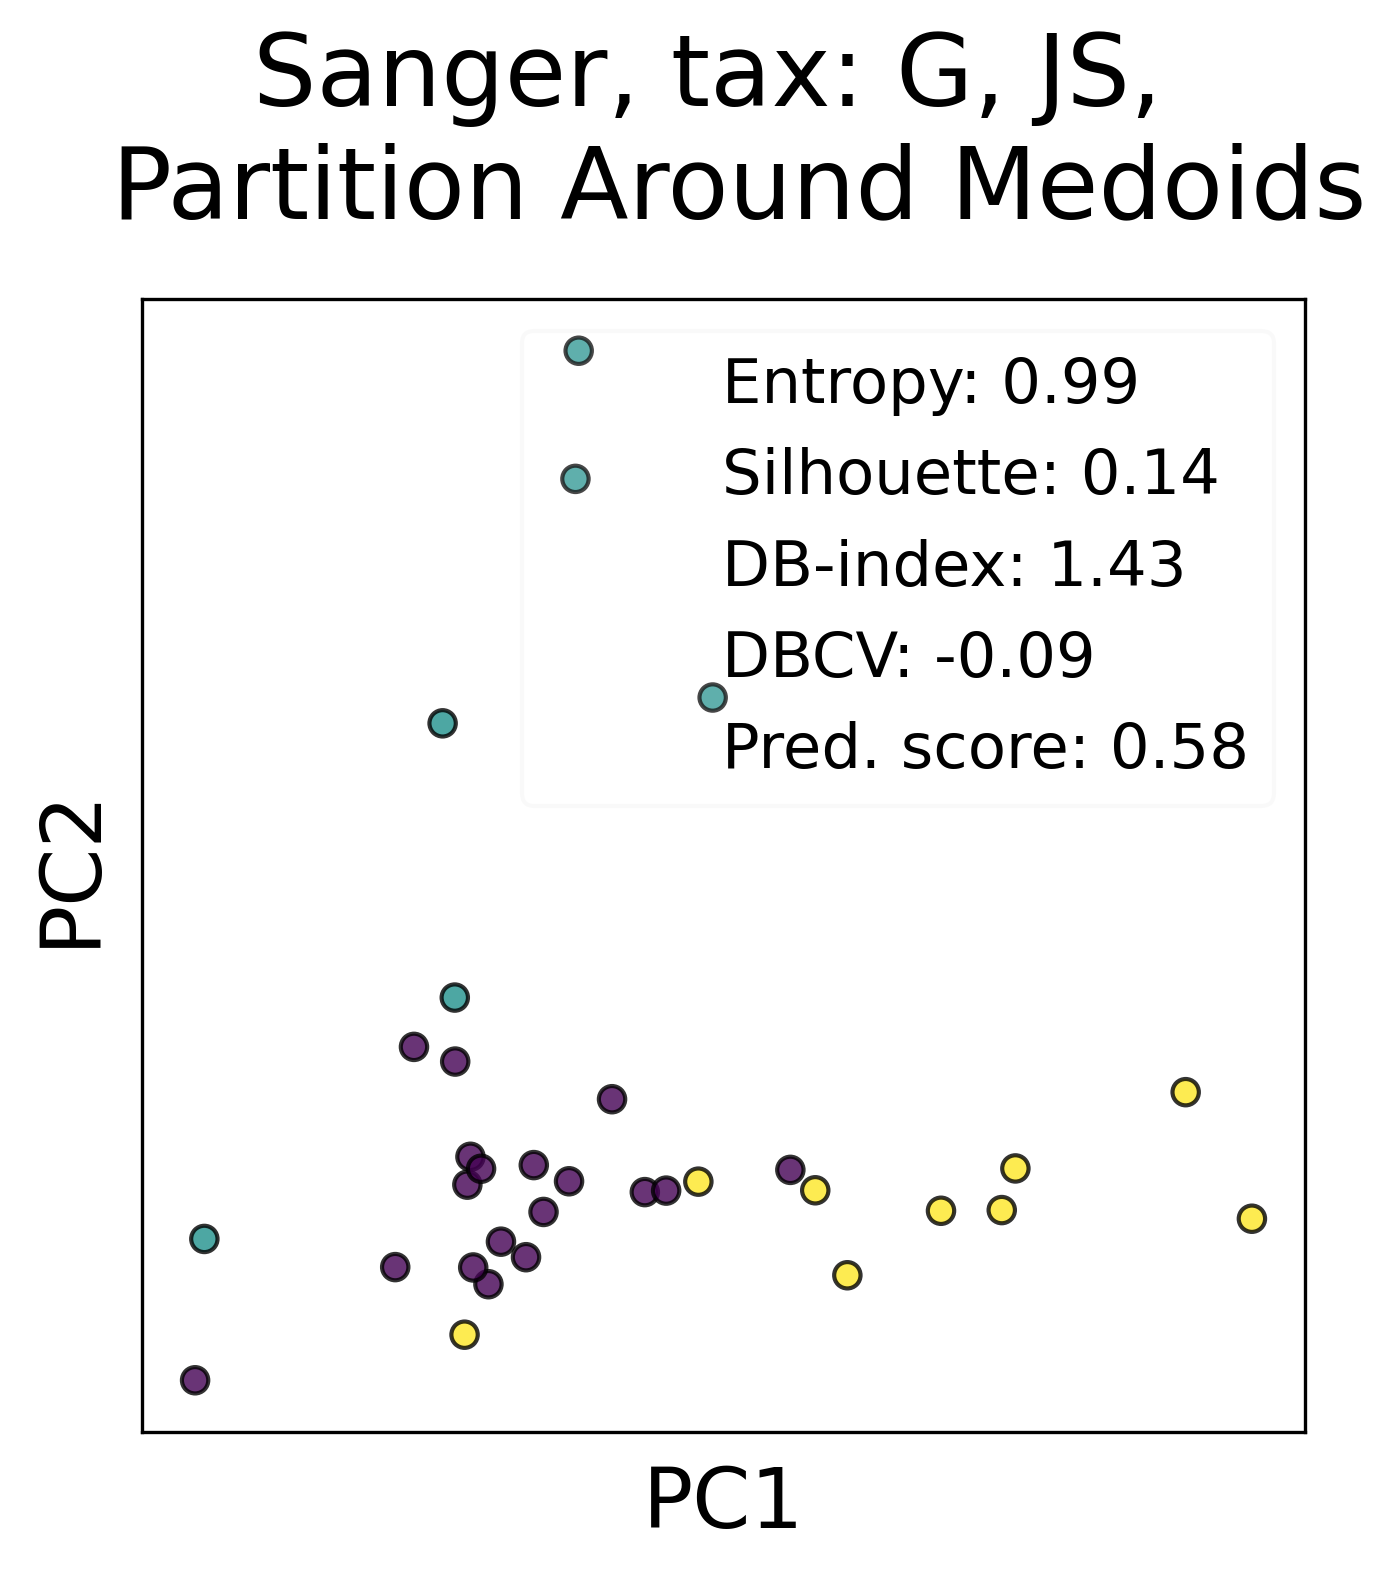

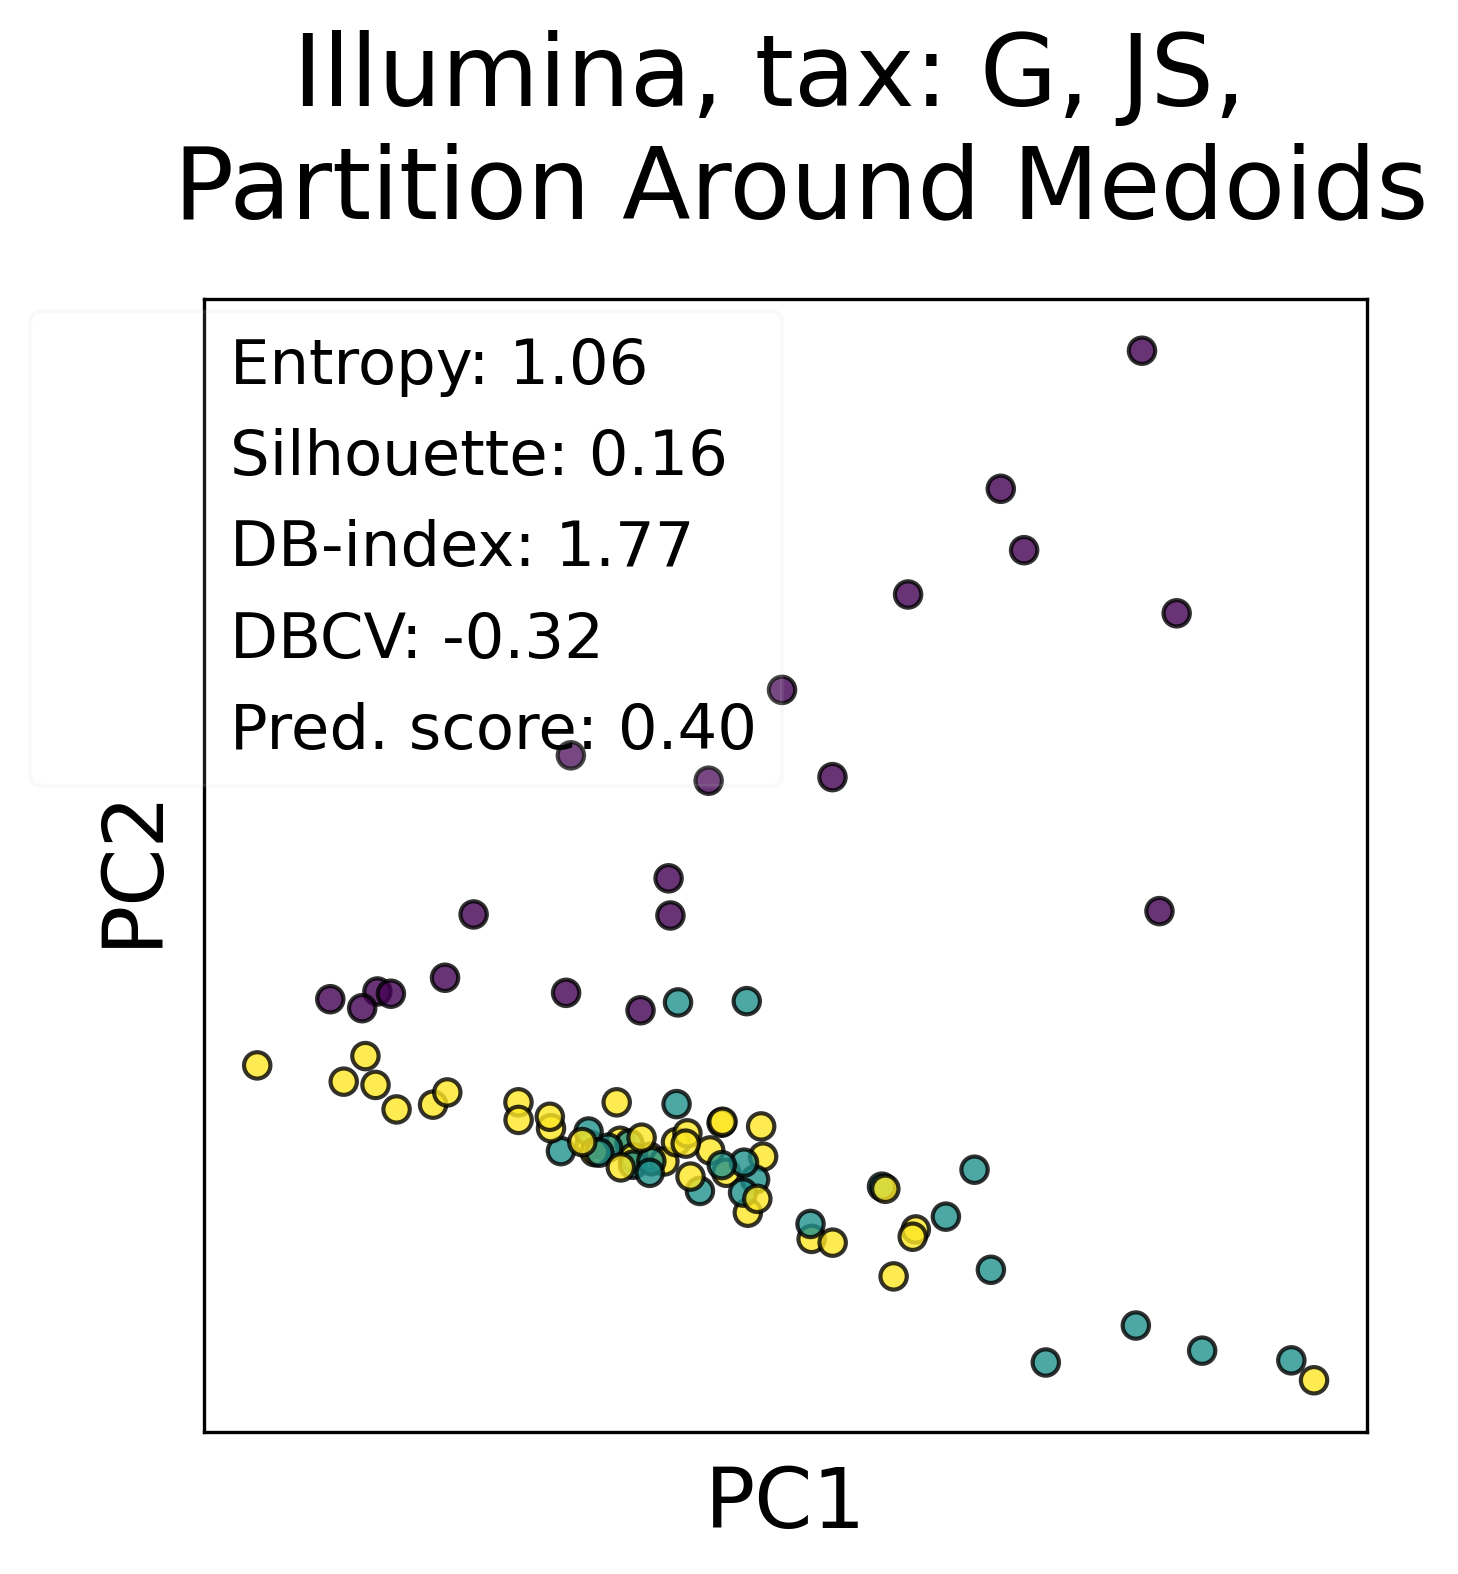

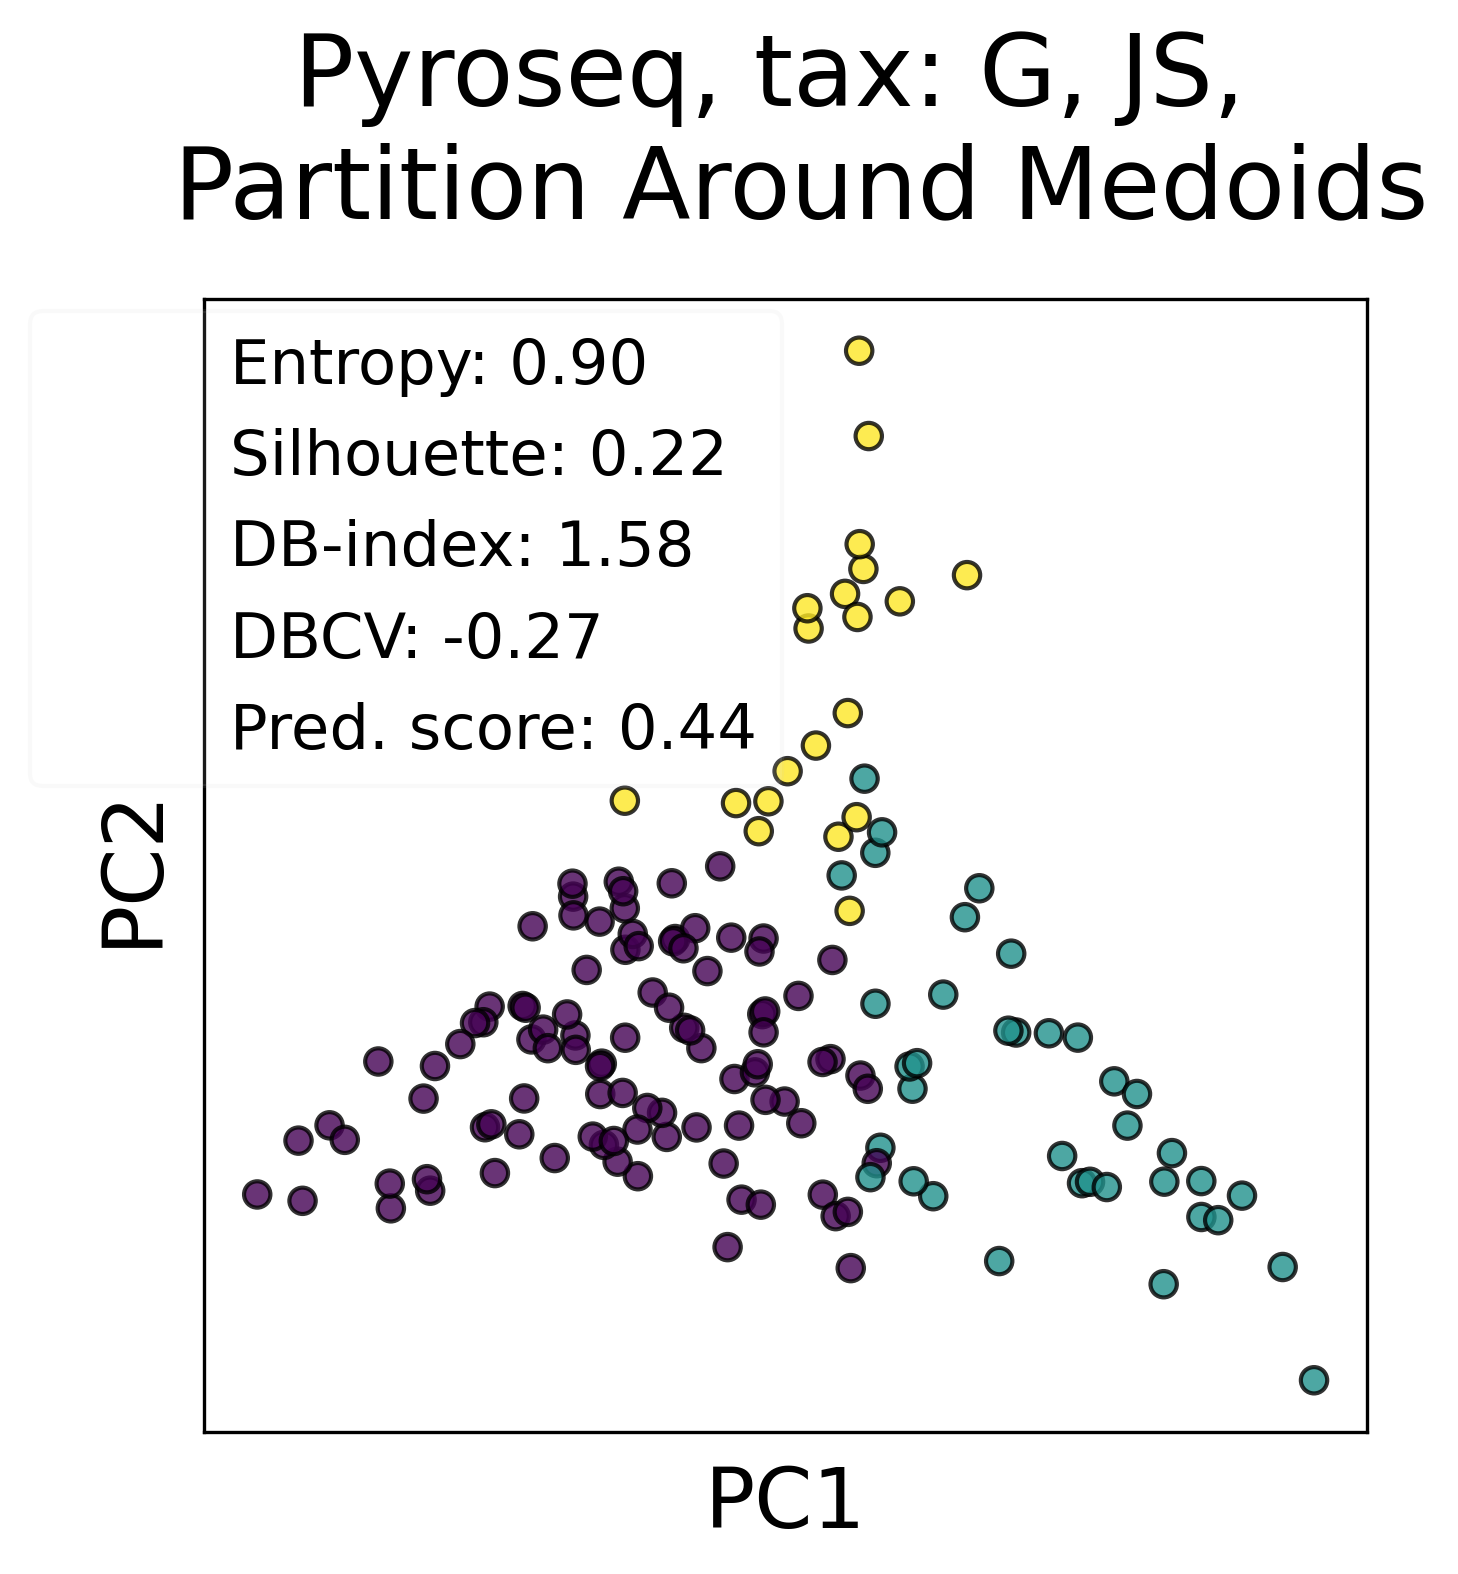

In [153]:
locs = {
    'Sanger_g':'best',
    'Illumina_g':(-0.15,0.57),
    'Pyroseq_g':(-0.15,0.57)
}

for label, results_label in results.items():

    X = data_pca[label]
    y = results_label['labels']

    entropy = results_label['entropy']
    silh = results_label['silh']
    dbind = results_label['dbind']
    dbcv = results_label['dbcv']
    ps = results_label['ps']

    plt.figure(figsize=(5,5), dpi=300)

    plt.scatter(
                X[:,0], 
                X[:,1],
                c=y,
                edgecolors='black',
                s=40,
                alpha=0.8,
               )

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xticks([])
    plt.yticks([])

    handles, labels = plt.gca().get_legend_handles_labels()

    text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(entropy))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='Pred. score: {:.2f}'.format(ps))
    handles.append(text_handle)


    # Add the arbitrary information patch to the legend handles
    legend = plt.legend(handles=handles, 
                        loc=locs[label], 
                        fontsize=15, 
                        frameon=True, 
                        fancybox=True, 
                        framealpha=0.1)
    
    dataset_name = label.split('_')[0]
    plt.title(f'{dataset_name}, tax: G, JS, \n Partition Around Medoids')
    
    plt.show()

In [ ]:
for label,X in data_pca.items():

In [119]:
clustering_results_root

'results/clustering_cpt-0.01_small_datasets'

# Dist clust

In [17]:
# methods_dict_distances = {
#                            'HDBSCAN':[HDBSCAN, 
#                               {
#                                'min_cluster_size':list(range(2,30)), 
#                                'alpha':[0.01, 0.5, 1.0, 1.5, 2.0],
#                                'cluster_selection_epsilon': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
#                               'min_samples':[None]+list(range(2,30)),
#                                'metric':['precomputed'],
#                                'core_dist_n_jobs':[1],
#                                'random_state':[42]}
#                                ],
#                            'KMedoids':[KMedoids, 
#                                        {'n_clusters':np.arange(2, 10, 1),
#                                         'method':['pam'],
#                                         'metric':['precomputed'],
#                                         'init':['k-medoids++'],
#                                         'random_state':[42]}],
#                            'SpectralClustering':[SpectralClustering_prec, 
#                                                  {'n_clusters':np.arange(2, 10, 1), 
#                                                   'gamma': np.linspace(1,7,num=10), # [1., 2, 3, 4, 5],
#                                                   'eigen_tol':[1e-4]}]
#                         }

In [20]:
# for distance_name, distance_dict in tqdm(distances_orig.items()):
    
#     results_path = os.path.join(clustering_results_root, f'{distance_name}_cluster_results')
    
# #     if os.path.isfile(results_path + '.npy'):
# #         print(f'{results_path} exists, skipping...')
# #         continue
    
#     distance_cluster_results = defaultdict(dict)
    
#     '''
#     list of dicts [
#                   dataset_1 ->  {'method1':[partition1, partition2], ...}
#                     , ...., 
#                   dataset_n ->  {'method1':[partition1, partition2], ...}
#                   ]
    
#     '''
#     clustering_data_results = Parallel(n_jobs=len(distance_dict),
#                                        mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
#                                                                                       methods_dict_distances,
#                                                                                       precomputed=True,
#                                                                                       d=data_orig[label].shape[1],
#                                                                                       cluster_perc_threshold=CPT)
#                                                             for label, data in distance_dict.items())


# #     for label, data in distance_dict.items():
# #         clustering_by_methods(data.astype('double'), 
# #                               methods_dict_distances,
# #                               precomputed=True,
# #                               d=data_orig[label].shape[1],
# #                               cluster_perc_threshold=CPT)

#     # create compatible metrics dicts
#     for i,label in enumerate(distance_dict.keys()):
#         for j, method_name in enumerate(methods_dict_distances.keys()):
#             distance_cluster_results[label][method_name] = clustering_data_results[i][method_name]

#     np.save(results_path, distance_cluster_results)
    
# clear_output()

# Clustering: PCA

In [24]:
# methods_dict = {
#                'HDBSCAN':[HDBSCAN, 
#                   {
#                    'min_cluster_size':list(range(2,30)), 
#                    'alpha':[0.01, 0.5, 1., 1.5, 2.0],
#                    'cluster_selection_epsilon': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
#                   'min_samples':[None]+list(range(2,30)),
#                    'core_dist_n_jobs':[1]}
#                    ],
#                'KMedoids':[KMedoids, 
#                            {'n_clusters':np.arange(2, 10, 1),
#                             'method':['pam'],
#                             'init':['k-medoids++'],
#                             'random_state':[42]}],
#                'SpectralClustering':[SpectralClustering, 
#                                      {'n_clusters':np.arange(2, 10, 1),
#                                       'affinity':['nearest_neighbors'],
#                                       'n_neighbors': list(range(1,30,2)), 
#                                      'eigen_tol':[1e-4],
#                                      'random_state':[42]}]
#              }

In [25]:
# ls -la results/clustering_cpt-0.01_small_datasets

In [27]:
# results_path = os.path.join(clustering_results_root, f'pca_cluster_results')

# pca_cluster_results = defaultdict(dict)

# clustering_data_results = Parallel(n_jobs=len(data_pca),
#                                    mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
#                                                                                   methods_dict,
#                                                                                   precomputed=False,
#                                                                                   d=data.shape[1],
#                                                                                   cluster_perc_threshold=CPT)
#                                                         for label, data in data_pca.items())

# # create compatible metrics dicts
# for i,label in enumerate(data_pca.keys()):
#     for j, method_name in enumerate(methods_dict.keys()):
#         pca_cluster_results[label][method_name] = clustering_data_results[i][method_name]

# np.save(results_path, pca_cluster_results)

# clear_output()

# Clustering: embeddings 

In [ ]:
# for embedding_type, embeddings in tqdm(data_embeddings.items()):
    
#     results_path = os.path.join(clustering_results_root, f'{embedding_type}_cluster_results')
    
#     if os.path.isfile(results_path + '.npy'):
#         print(f'{results_path} exists, skipping...')
#         continue
#     else:
#         print(f'{results_path} exists, calculating...')
    
#     embeddings_cluster_results = defaultdict(dict)
    
#     '''
#     list of dicts [
#                   dataset_1 ->  {'method1':[partition1, partition2], ...}
#                     , ...., 
#                   dataset_n ->  {'method1':[partition1, partition2], ...}
#                   ]
    
#     '''
#     clustering_data_results = Parallel(n_jobs=len(embeddings),
#                                        mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
#                                                                                       methods_dict,
#                                                                                       precomputed=False,
#                                                                                       d=data.shape[1],
#                                                                                       cluster_perc_threshold=CPT)
#                                                             for label, data in embeddings.items())

#     # create compatible metrics dicts
#     for i,label in enumerate(embeddings.keys()):
#         for j, method_name in enumerate(methods_dict.keys()):
#             embeddings_cluster_results[label][method_name] = clustering_data_results[i][method_name]

#     np.save(results_path, embeddings_cluster_results)
    
# clear_output()

In [86]:
clustering_results_root

'results/clustering_cpt-0.01_small_datasets'

In [87]:
ls -la results/clustering_cpt-0.01_small_datasets

total 45396
drwxr-xr-x  2 ibulygin users     4096 апр  7 18:15 ./
drwxr-xr-x 18 ibulygin users     4096 апр 11 19:25 ../
-rw-r--r--  1 ibulygin users 11217365 апр  7 16:50 BC_cluster_results.npy
-rw-r--r--  1 ibulygin users 17328346 апр  7 16:48 JS_cluster_results.npy
-rw-r--r--  1 ibulygin users  5452883 апр  7 16:42 L1_cluster_results.npy
-rw-r--r--  1 ibulygin users  9869010 апр  7 16:45 L2_cluster_results.npy
-rw-r--r--  1 ibulygin users  2599904 апр  7 18:15 pca_cluster_results.npy


# Microbiome data

In [90]:
# ['lle', 'L1', 'pca', ...]
representations_names = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

clustering_results_df = []

for representation in representations_names:
    
    clustreing_results_path = os.path.join(clustering_results_root, f'{representation}_cluster_results.npy')
    cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
    # results for each datset
    for label, cl_res_label in cluster_results.items():
        #results for each method given dataset
        for cl_method, cl_res_label_method in cl_res_label.items():
            
            if len(cl_res_label_method) == 0:
                print('Empty results for:', representation, label, cl_method)
                continue
                
            df = pd.DataFrame(cl_res_label_method)
            
#             cl_res_label_method_ = {k:v[0] for k,v in cl_res_label_method.items()}
#             df = pd.DataFrame(cl_res_label_method_).T
            
            dataset, tax = label.split('_')
            
            df['dataset'] = dataset
            df['tax'] = tax
            df['representation'] = representation
            df['cl_method'] = cl_method
            # n_clusters found
            n_unique = lambda x: len(np.unique(x[x!=-1]))
            df['n_cl'] = df['labels'].apply(n_unique)
            
            clustering_results_df.append(df)
            
clustering_results_df = pd.concat(clustering_results_df, axis=0, ignore_index=True)

In [91]:
df_mask = (clustering_results_df['data_used'] > DATA_PRESERVED_THRESHOLD) &\
          (clustering_results_df['dbind'] < DBIND_MAX)  &\
          (~clustering_results_df['dbcv'].isna())

clustering_results_df_ = clustering_results_df[df_mask]

In [92]:
clustering_results_df_['cl_method'].value_counts()

HDBSCAN               11246
SpectralClustering     1144
KMedoids                 96
Name: cl_method, dtype: int64

# Davies-Bouldin index and Silhoutte score, entropy coloring

## Sanger

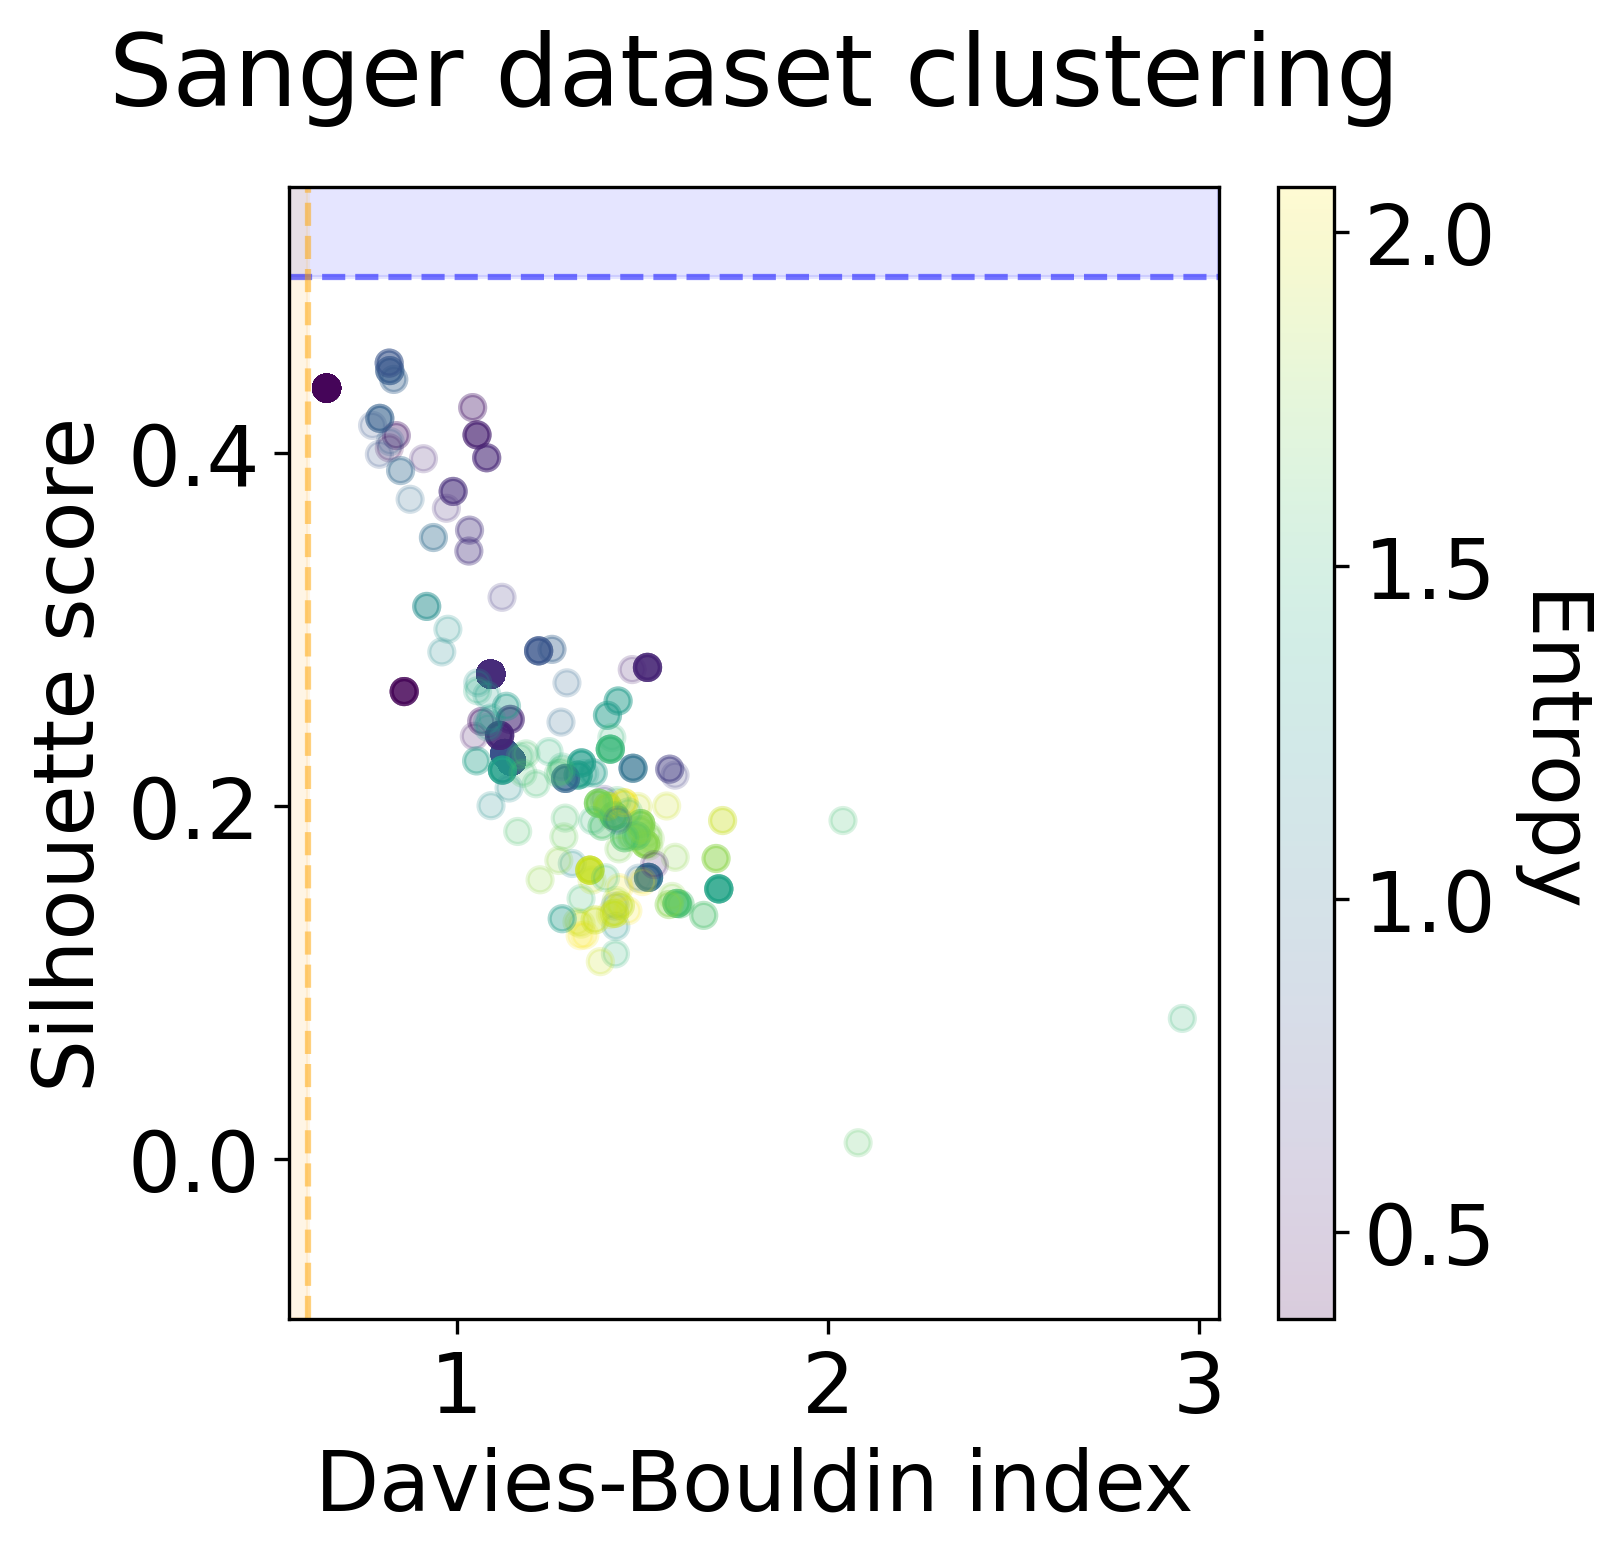

In [121]:
Sanger_df_silh = clustering_results_df_.query('dataset == "Sanger"')

plot_clustering_scatter(Sanger_df_silh, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Sanger dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

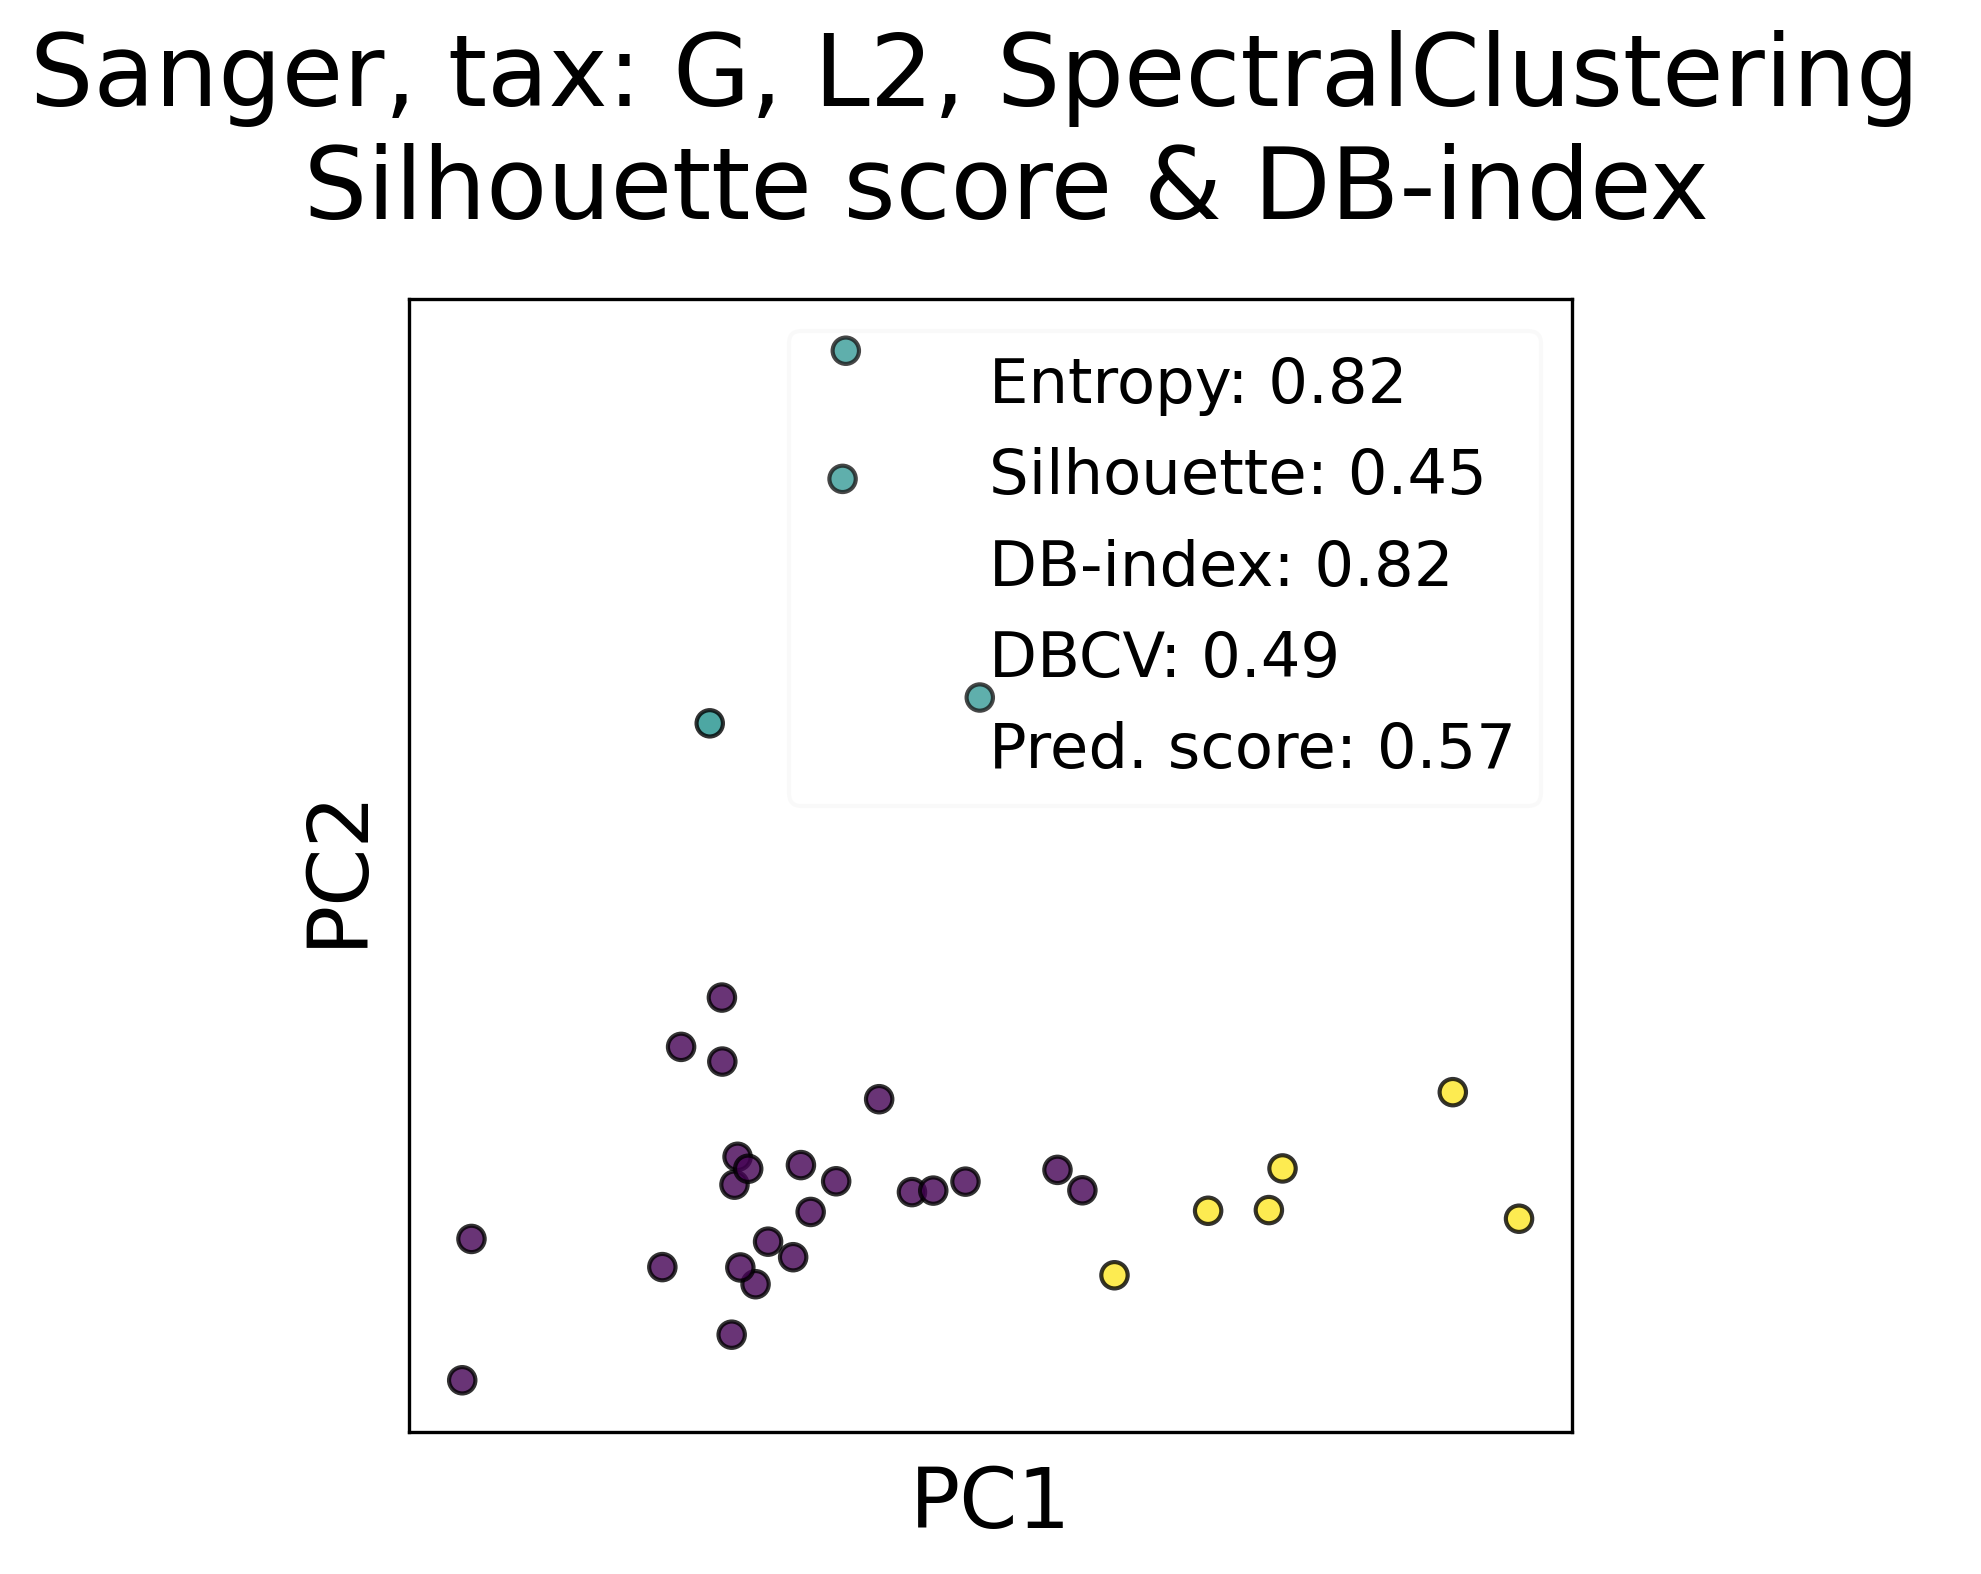

In [122]:
df_selected = Sanger_df_silh

idx = (df_selected['silh']).idxmax()
best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Sanger_g'][:,:2][df_mask]

entropy, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)


RI = rand_score(results_final['Sanger_g'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(entropy))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. score: {:.2f}'.format(ps))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc='best', 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

# plt.setp(legend.get_bbox_patch(), boxstyle='round', alpha=0.5)
# legend.get_bbox_patch().set_boxstyle('round,pad=0.2')
# legend.get_bbox_patch().set_transform(plt.gcf().transFigure)
# legend.get_bbox_patch().set_bounds(0.4, 0.5, 0.2, 0.2)


# frame = legend.get_frame()
# # frame.set_height(0.5)
# # frame.set_width(0.1)

# frame.set_bounds(1,1,10,10)

plt.title(f'Sanger, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

In [123]:
rand_score(results_final['Sanger_g'], y)

0.7689393939393939

([], [])

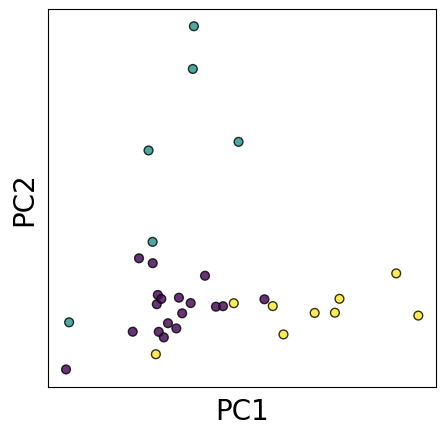

In [124]:
plt.figure(figsize=(5,5), dpi=100)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=results_final['Sanger_g'],
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])


## Illumina

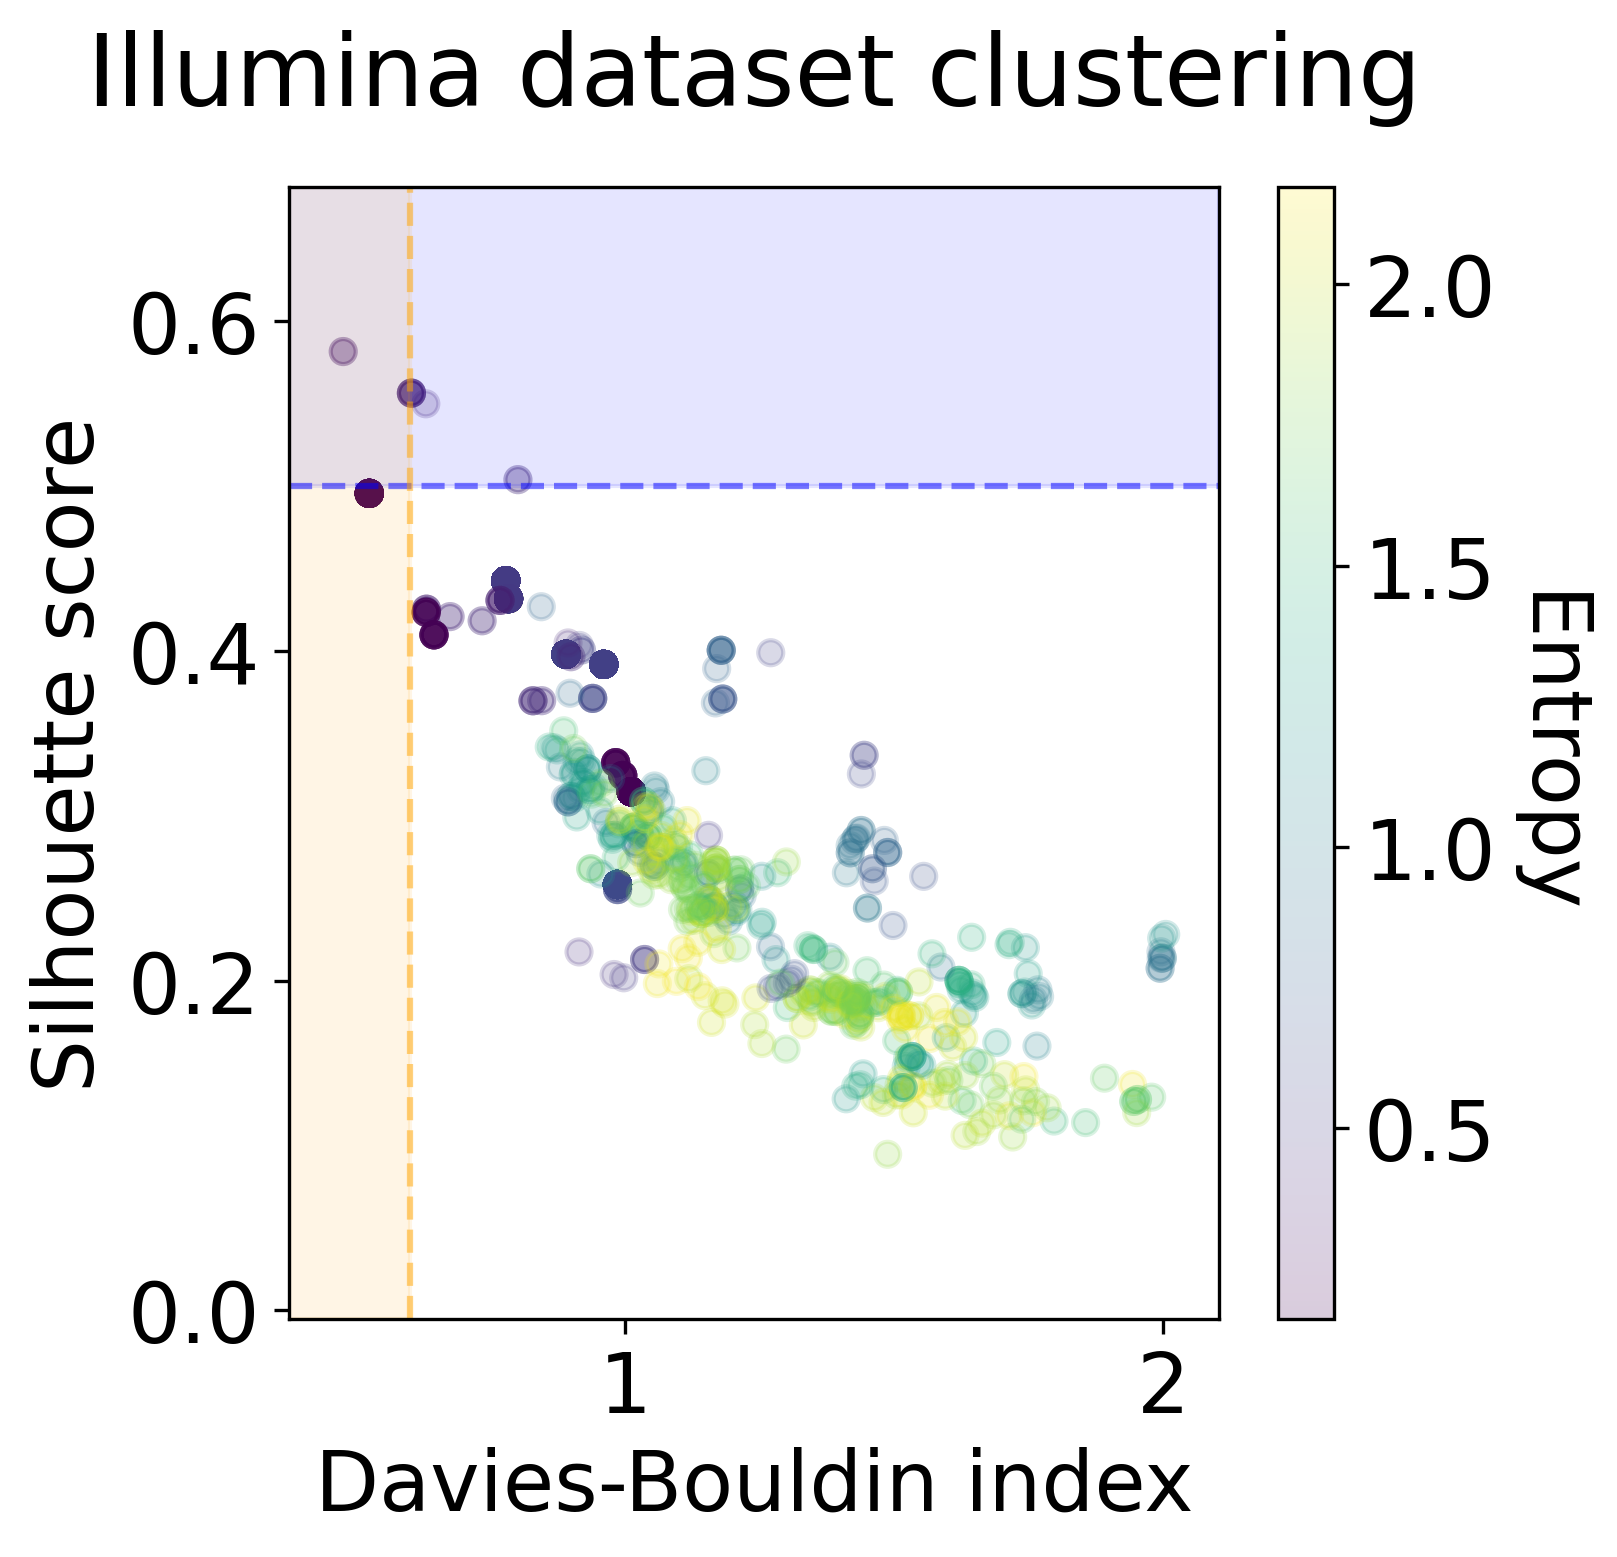

In [125]:
Illumina_df = clustering_results_df_.query('dataset == "Illumina"')

plot_clustering_scatter(Illumina_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Illumina dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

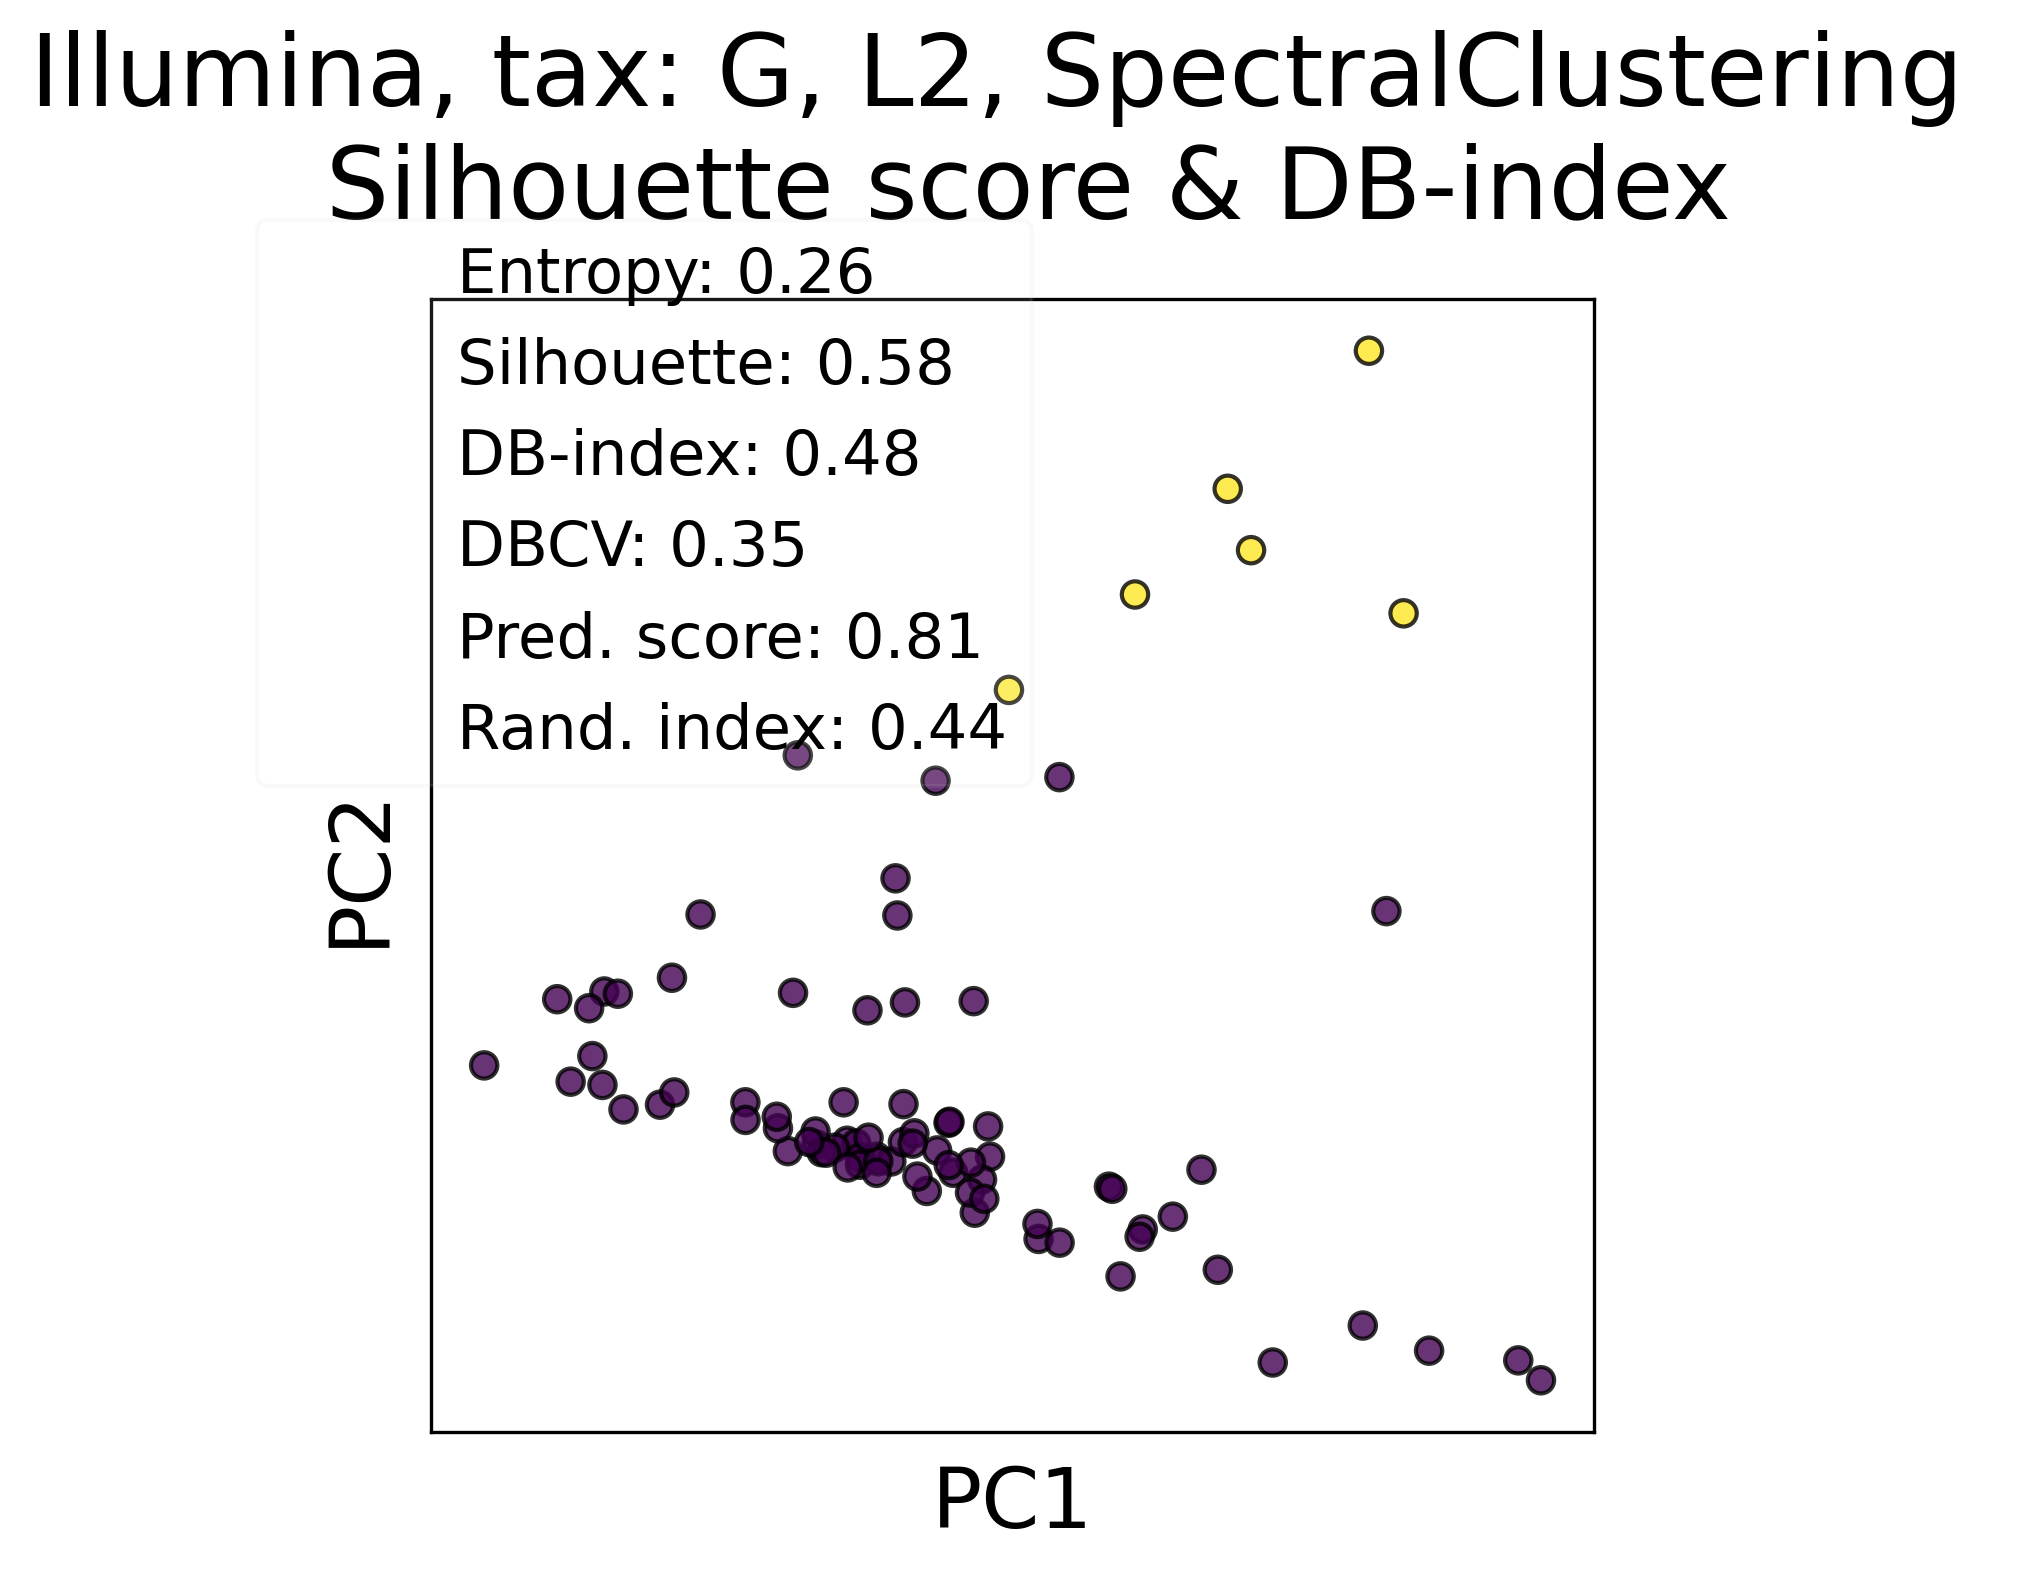

In [129]:
df = Illumina_df
selection_mask_df = (df['silh'] >= SILHOUETTE_THRESH-5e-3) * (df['dbind'] <= DBIND_THRESHOLD+5e-3)
df_selected = df[selection_mask_df]

idx = df_selected['silh'].idxmax()
best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Illumina_g'][:,:2][df_mask]

entropy, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = rand_score(results_final['Illumina_g'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(entropy))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. score: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.57), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

# plt.setp(legend.get_bbox_patch(), boxstyle='round', alpha=0.5)
# legend.get_bbox_patch().set_boxstyle('round,pad=0.2')
# legend.get_bbox_patch().set_transform(plt.gcf().transFigure)
# legend.get_bbox_patch().set_bounds(0.4, 0.5, 0.2, 0.2)


# frame = legend.get_frame()
# # frame.set_height(0.5)
# # frame.set_width(0.1)

# frame.set_bounds(1,1,10,10)
plt.title(f'Illumina, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

([], [])

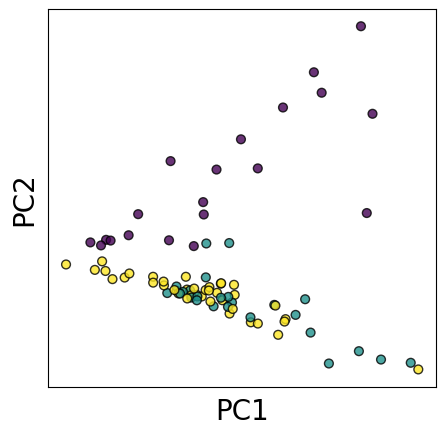

In [128]:
plt.figure(figsize=(5,5), dpi=100)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=results_final['Illumina_g'],
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])


## Pyroseq

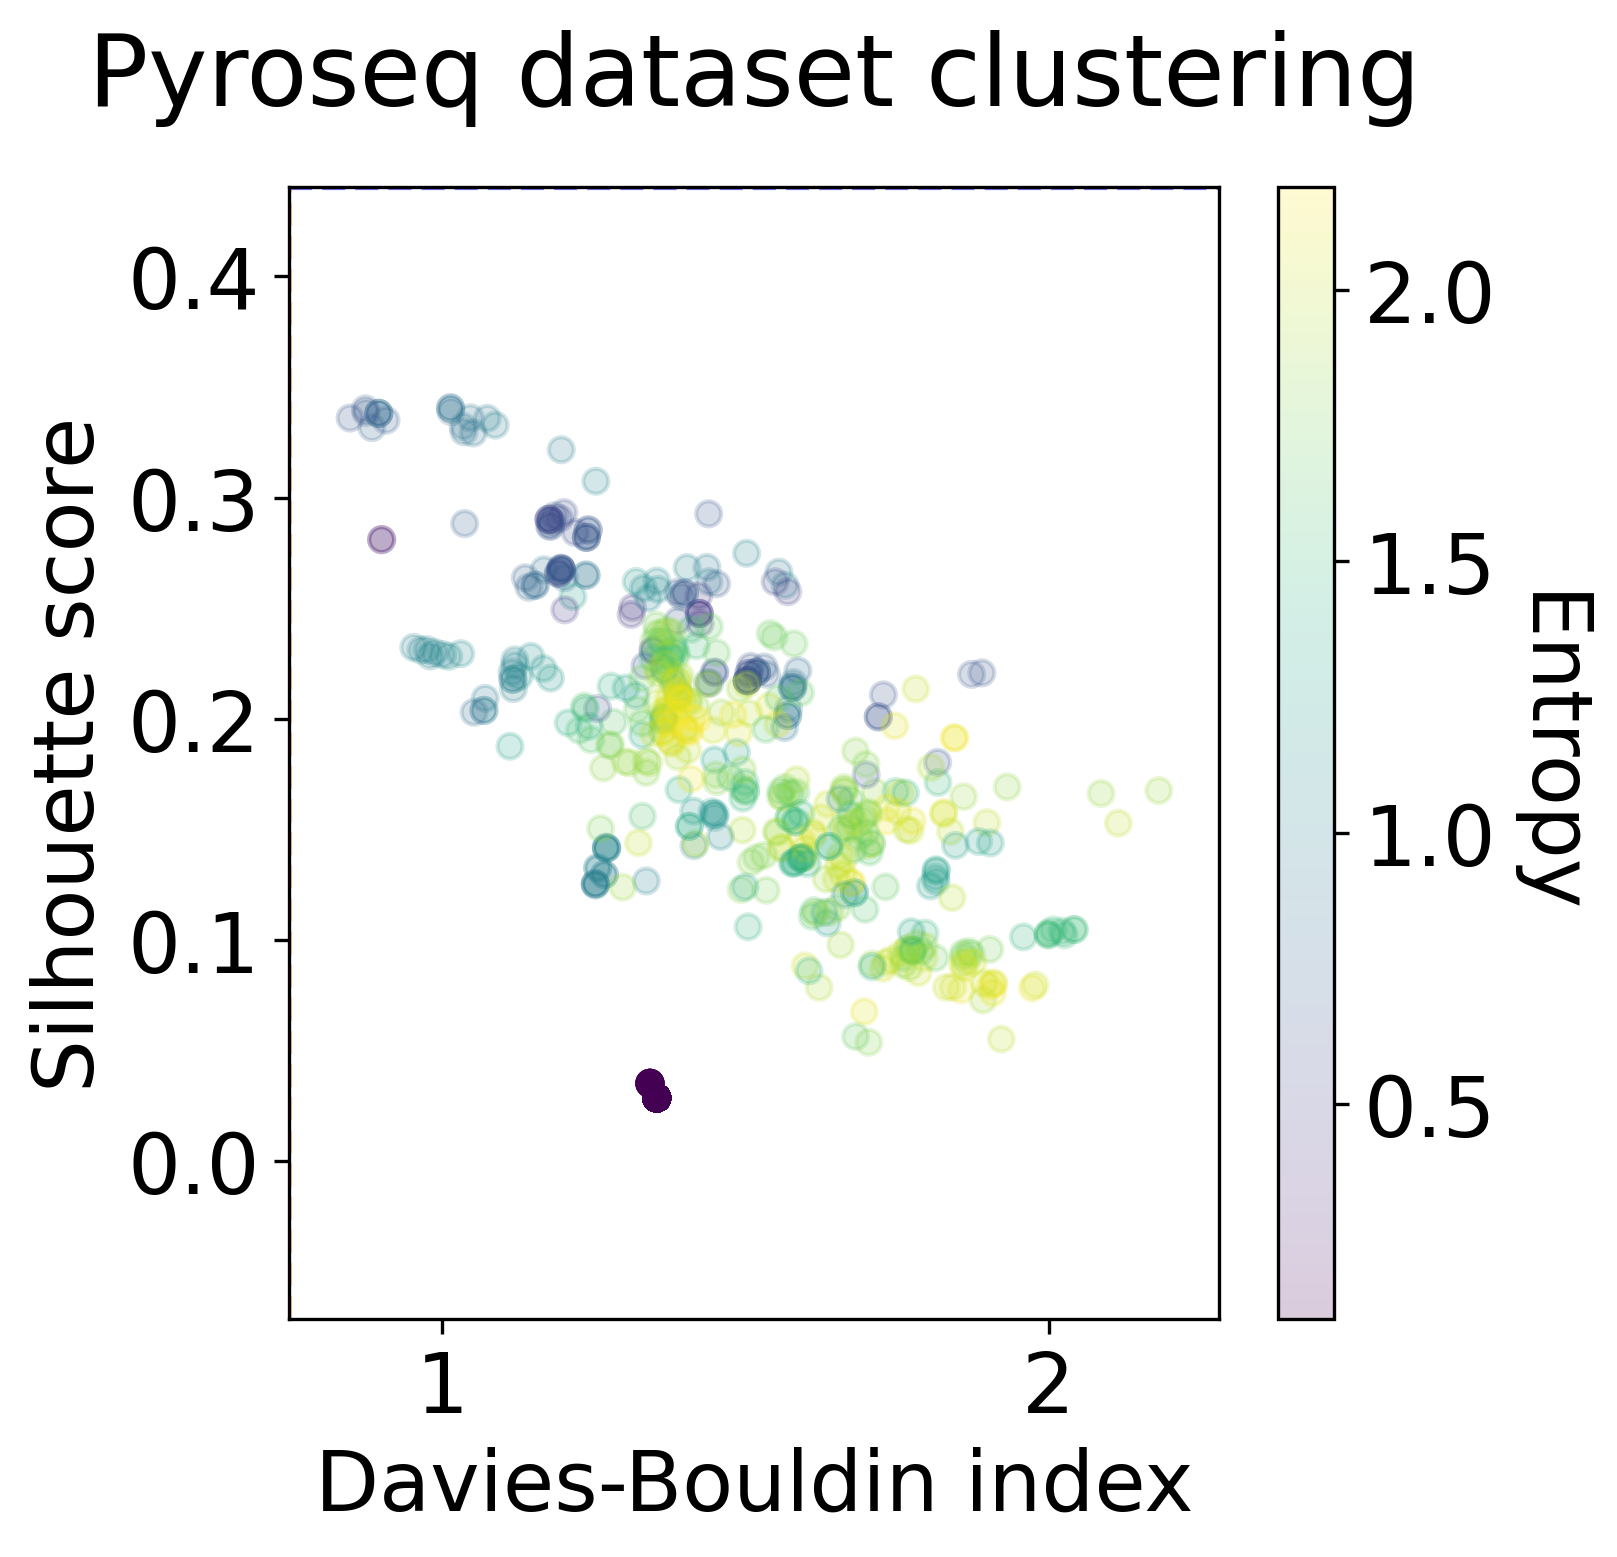

In [112]:
Pyroseq_df = clustering_results_df_.query('dataset == "Pyroseq"')

plot_clustering_scatter(Pyroseq_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Pyroseq dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

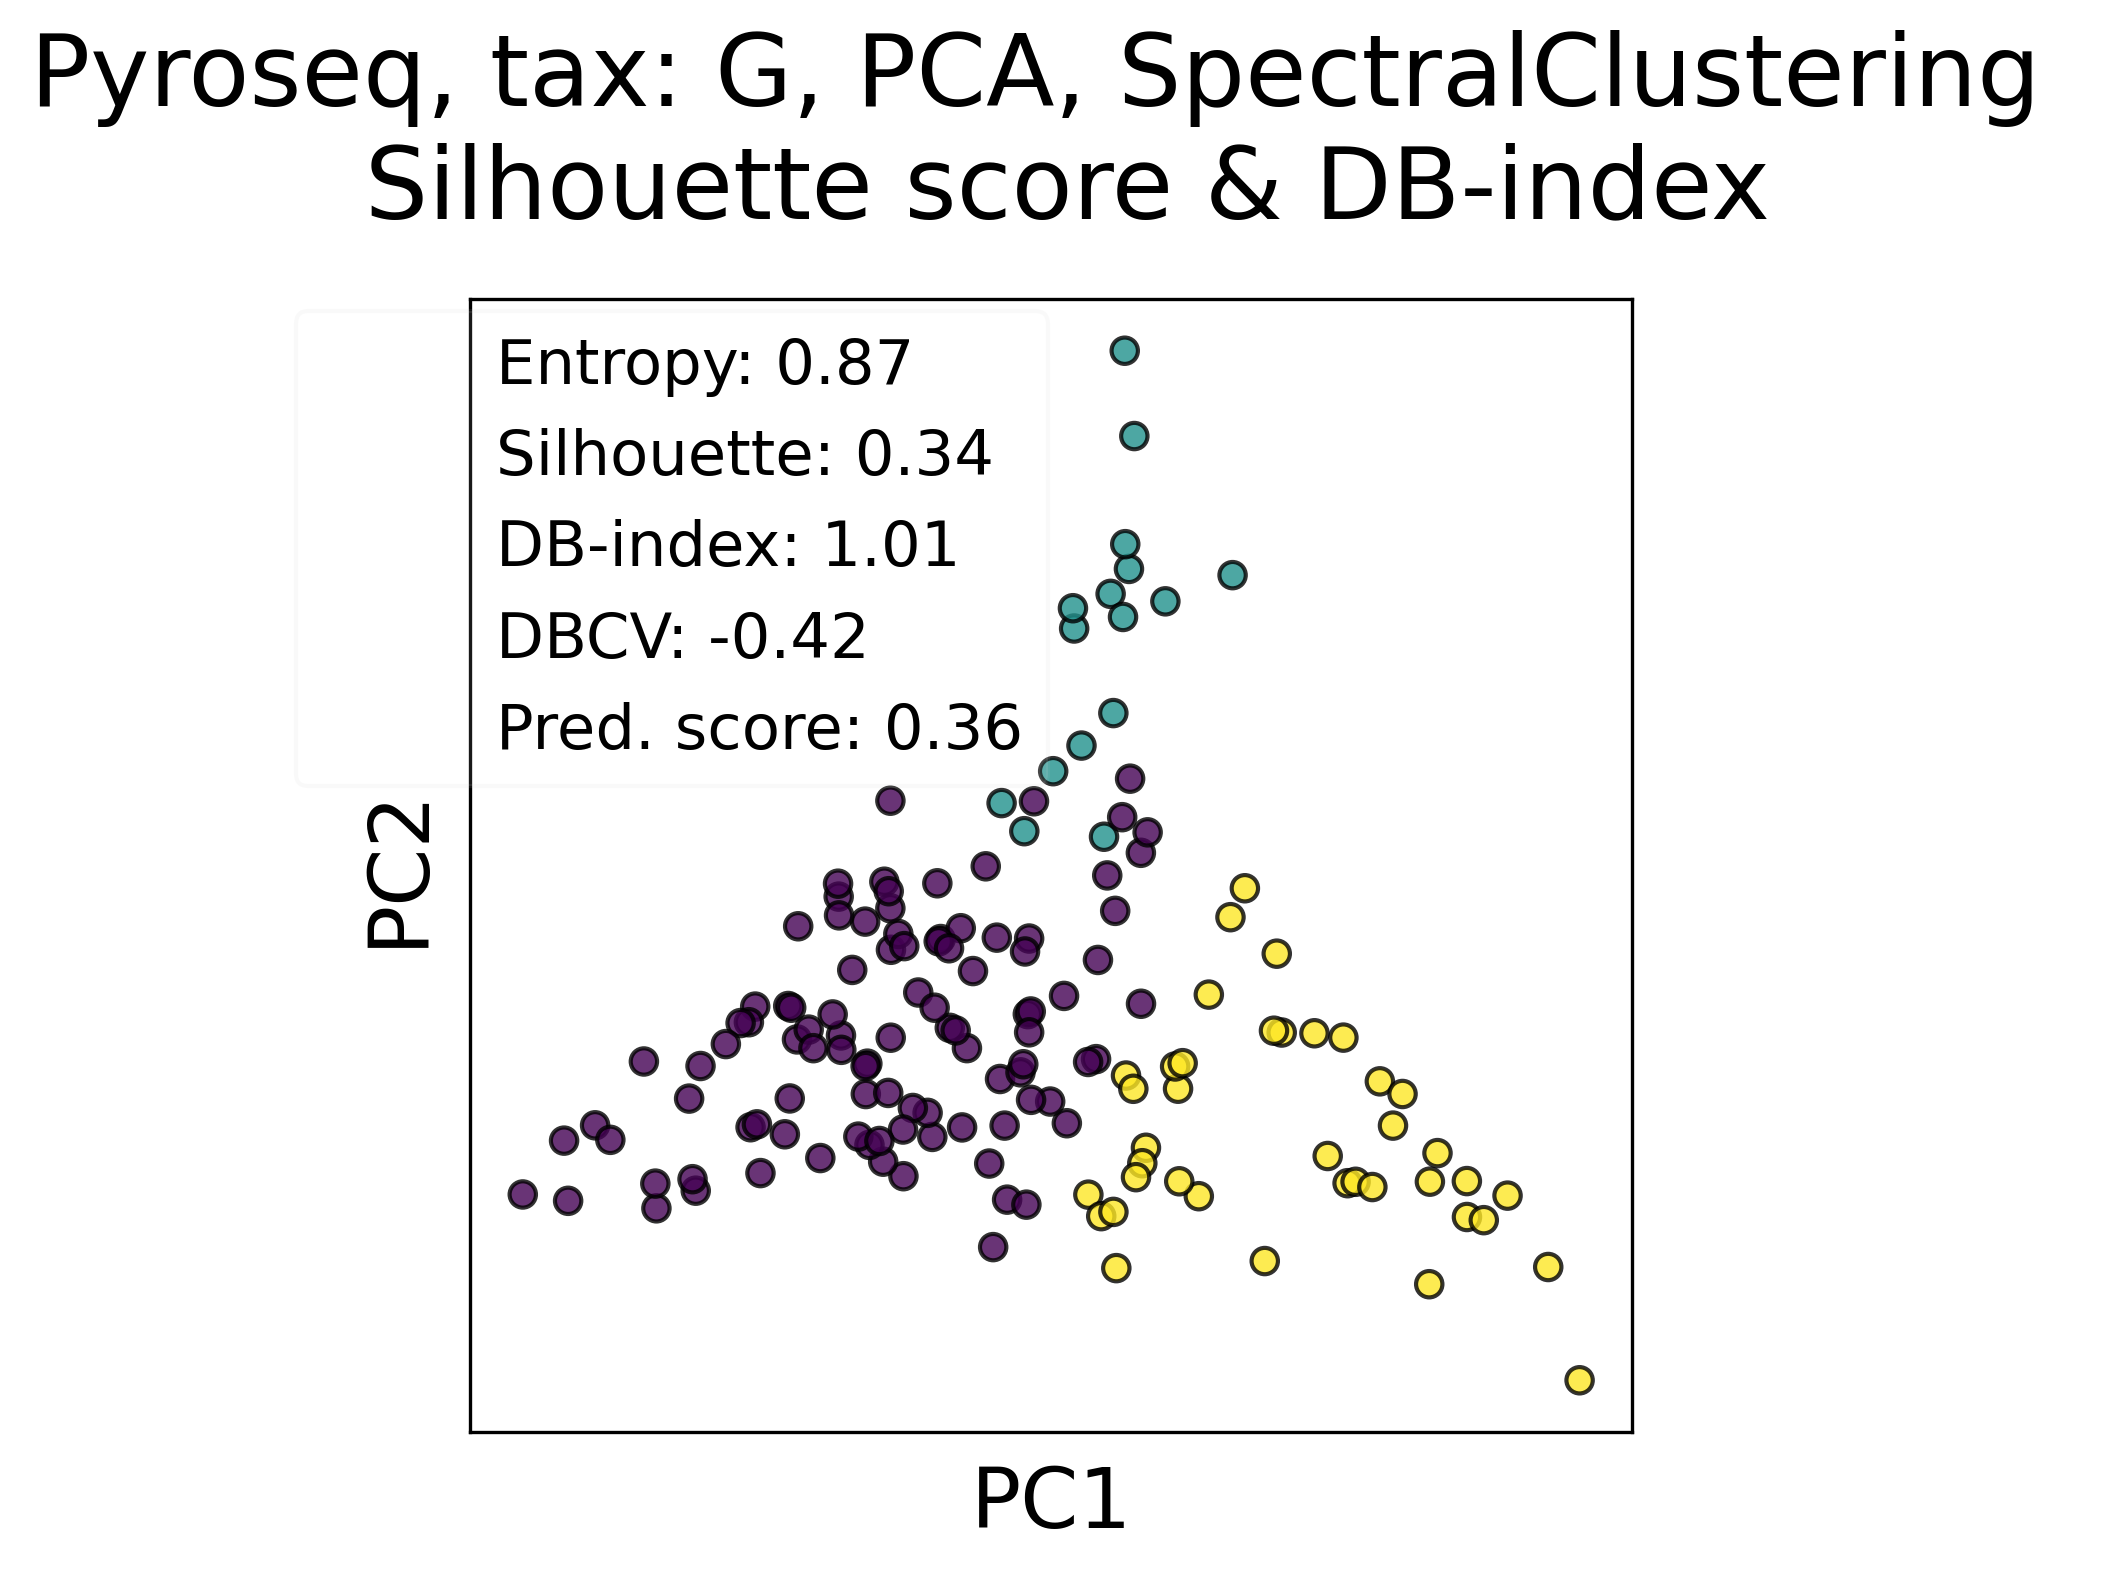

In [113]:
df_selected = Pyroseq_df

idx = df_selected['silh'].idxmax()
best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Pyroseq_g'][:,:2][df_mask]

entropy, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)



RI = rand_score(results_final['Pyroseq_g'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(entropy))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. score: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.57), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

# plt.setp(legend.get_bbox_patch(), boxstyle='round', alpha=0.5)
# legend.get_bbox_patch().set_boxstyle('round,pad=0.2')
# legend.get_bbox_patch().set_transform(plt.gcf().transFigure)
# legend.get_bbox_patch().set_bounds(0.4, 0.5, 0.2, 0.2)


# frame = legend.get_frame()
# # frame.set_height(0.5)
# # frame.set_width(0.1)

# frame.set_bounds(1,1,10,10)
plt.title(f'Pyroseq, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

([], [])

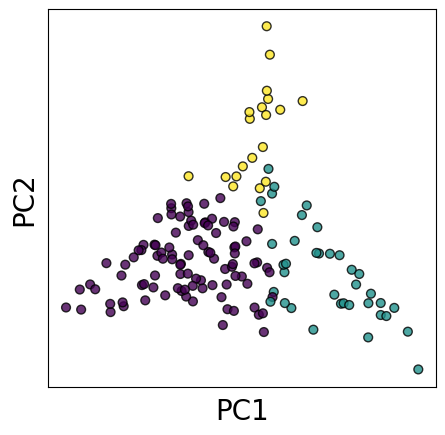

In [116]:
plt.figure(figsize=(5,5), dpi=100)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=results_final['Pyroseq_g'],
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])


## Sanger

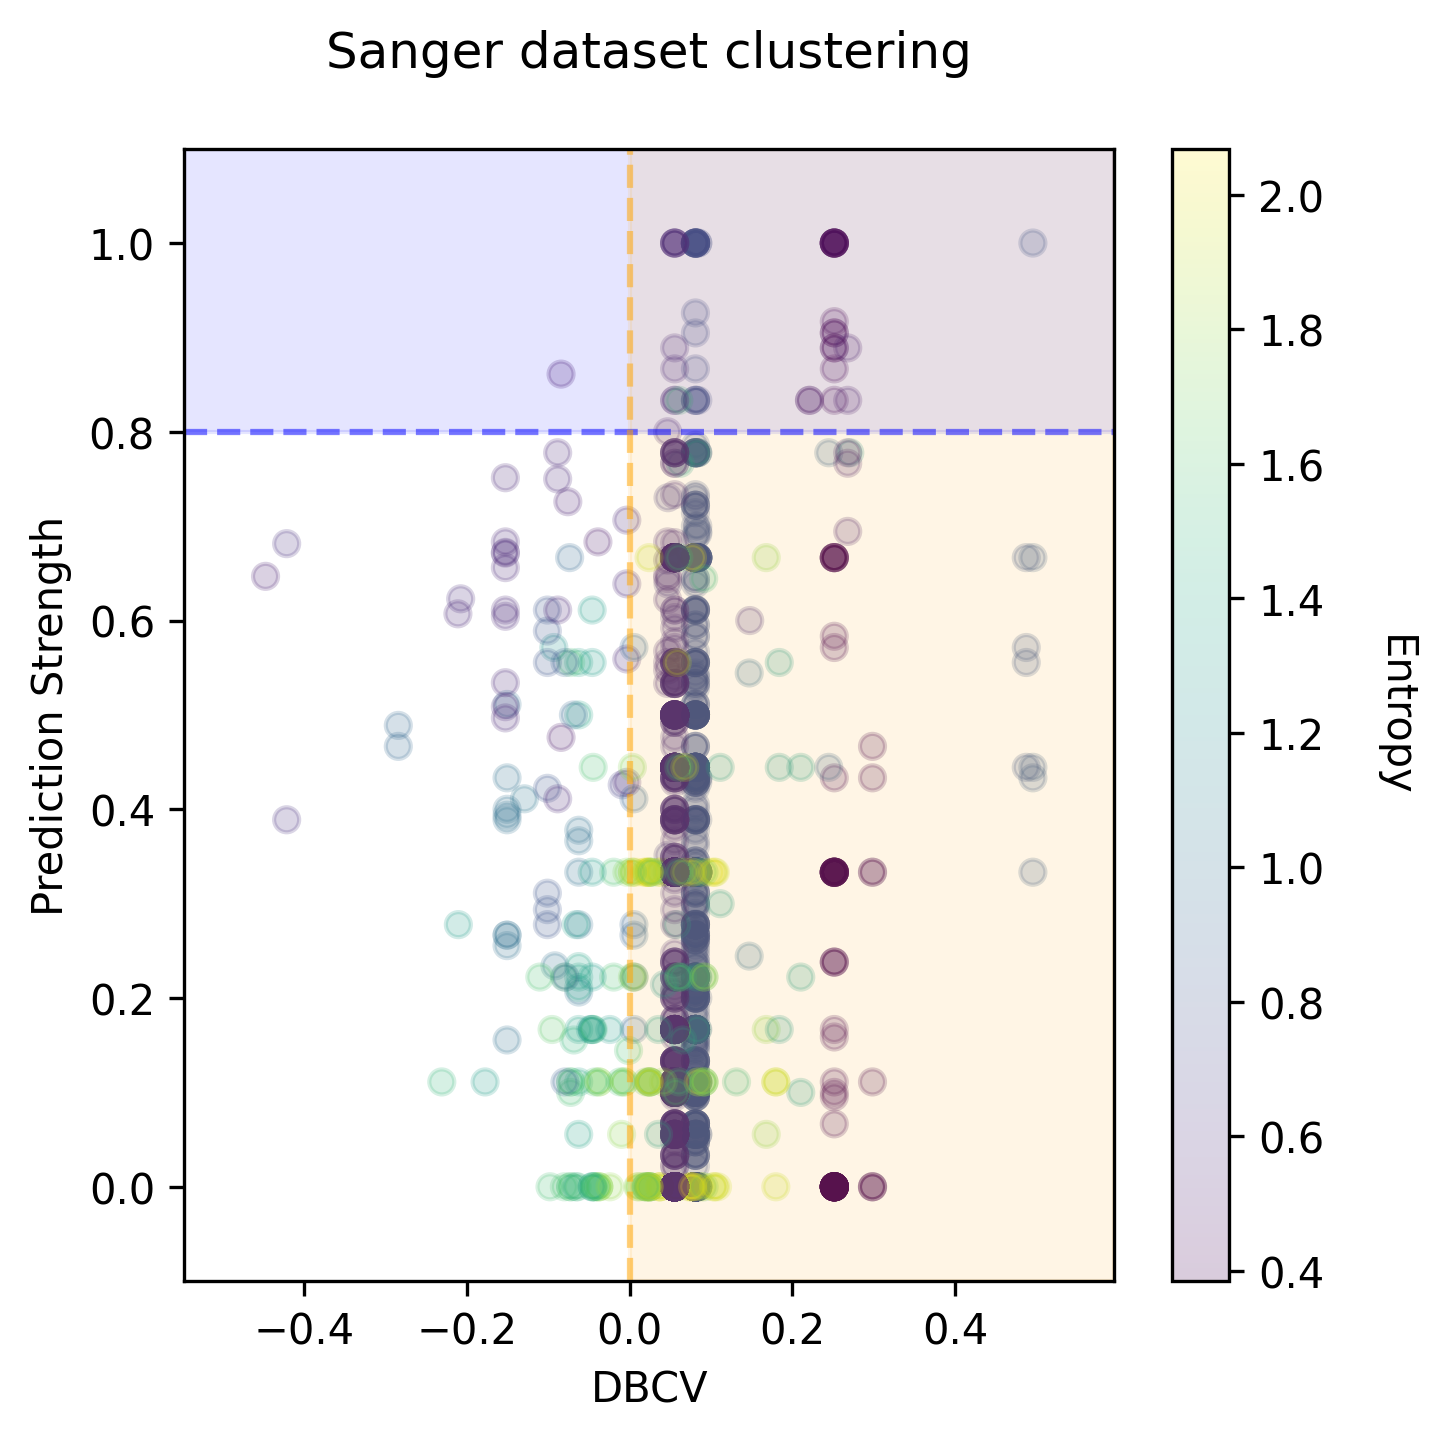

In [46]:
Sanger_df = clustering_results_df_.query('dataset == "Sanger"')

plot_clustering_scatter(Sanger_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Sanger dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [47]:
# Sanger_df_selected['hash'] = Sanger_df_selected[['dataset',
#                                                'tax',
#                                                'representation',
#                                                'cl_method',
#                                                'n_cl']].astype(str).sum(1)

# idx = Sanger_df_selected.groupby('hash')['entropy'].transform(max) == Sanger_df_selected['entropy']
# Sanger_df_selected[idx][['dataset', 'tax', 'representation', 'cl_method', 'n_cl', 'dbind','silh', 'dbcv', 'ps', 'entropy']].round(2)

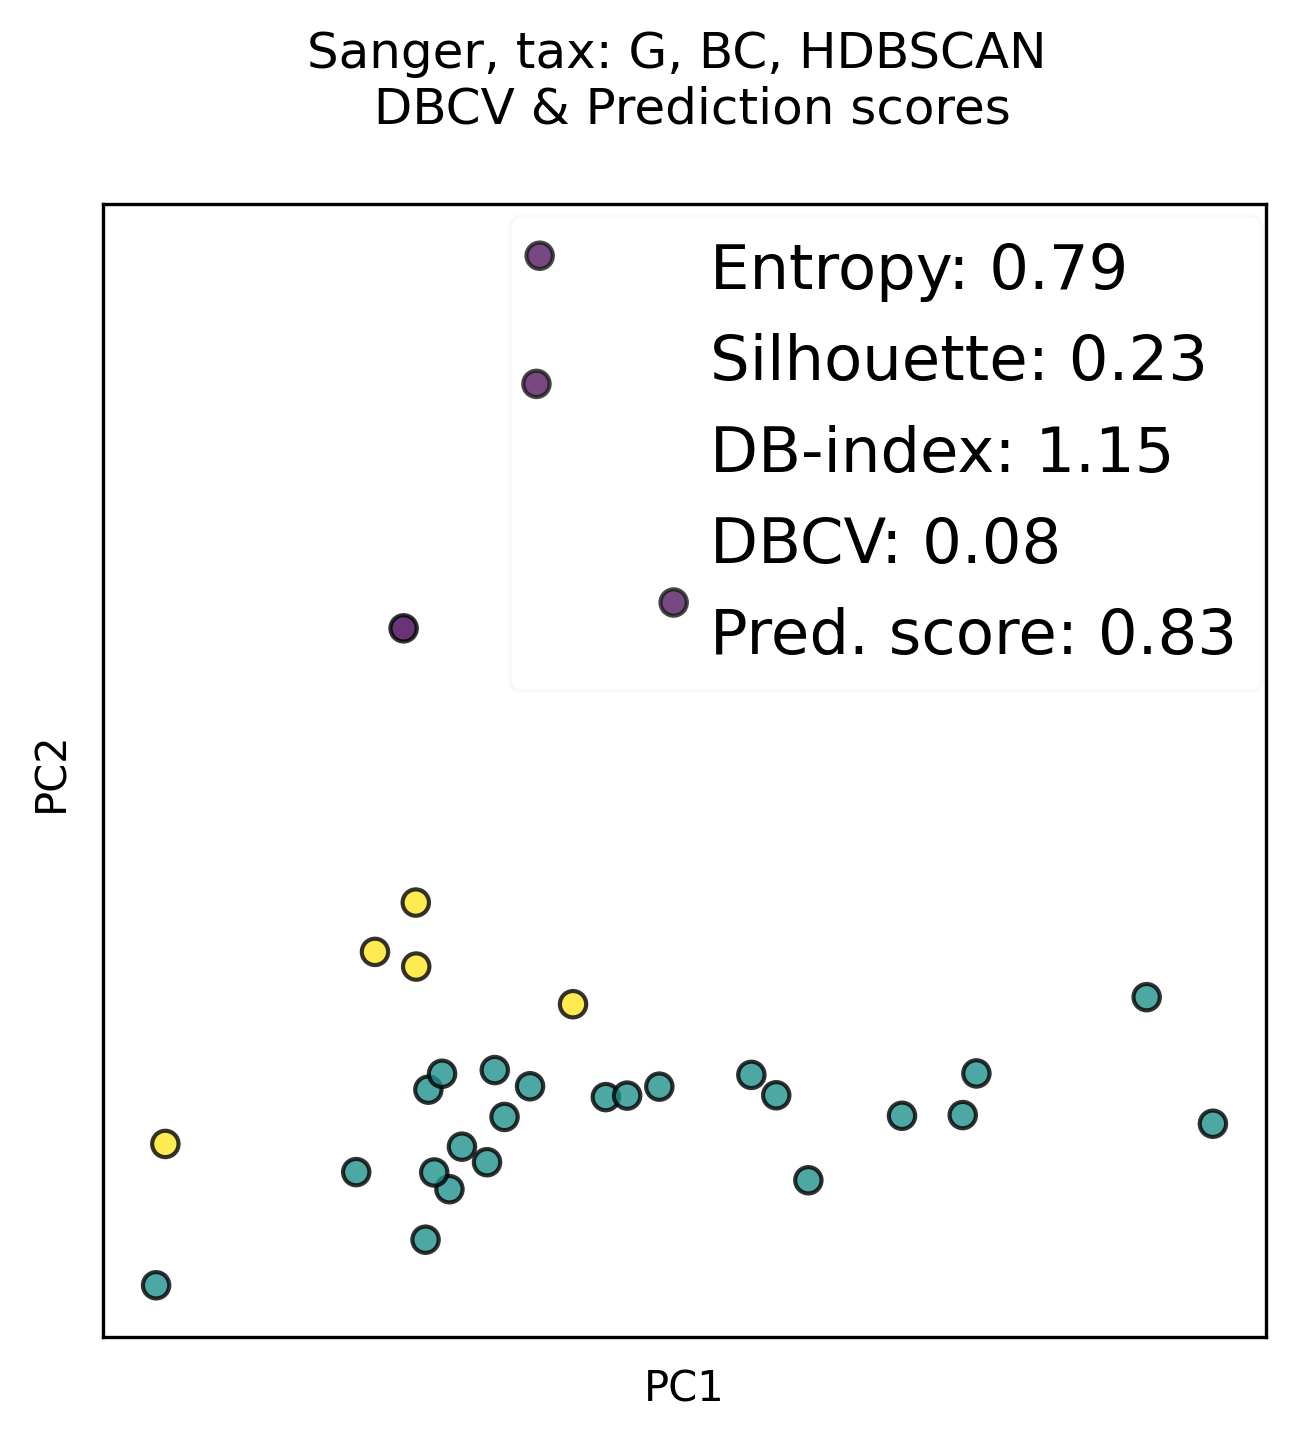

In [48]:
selection_mask_Sanger = (Sanger_df['dbcv'] > DBCV_THRESHOLD) * (Sanger_df['ps'] > PS_THRESHOLD)
df_selected = Sanger_df[selection_mask_Sanger]

idx = (df_selected['ps'] + df_selected['dbcv']).idxmax()

for idx in df_selected.index:

    best_clustering = df_selected.loc[idx]
    y = best_clustering['labels']
    df_mask = best_clustering['mask']
    X_repr = best_clustering['representation']
    X_tax = best_clustering['tax']
    X_cl_method = best_clustering['cl_method']

    X = data_pca['Sanger_g'][:,:2][df_mask]

    entropy, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                              dtype=np.float32).round(2)

    plt.figure(figsize=(5,5), dpi=300)

    plt.scatter(
                coord_to_pix(X[:,0]), 
                coord_to_pix(X[:,1]),
                c=y,
                edgecolors='black',
                s=40,
                alpha=0.8,
               )

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xticks([])
    plt.yticks([])

    handles, labels = plt.gca().get_legend_handles_labels()

    text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(entropy))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='Pred. score: {:.2f}'.format(ps))
    handles.append(text_handle)

    # Add the arbitrary information patch to the legend handles
    legend = plt.legend(handles=handles, 
                        loc=(0.35,0.57), 
                        fontsize=15, 
                        frameon=True, 
                        fancybox=True, 
                        framealpha=0.1)

    # plt.setp(legend.get_bbox_patch(), boxstyle='round', alpha=0.5)
    # legend.get_bbox_patch().set_boxstyle('round,pad=0.2')
    # legend.get_bbox_patch().set_transform(plt.gcf().transFigure)
    # legend.get_bbox_patch().set_bounds(0.4, 0.5, 0.2, 0.2)


    # frame = legend.get_frame()
    # # frame.set_height(0.5)
    # # frame.set_width(0.1)

    # frame.set_bounds(1,1,10,10)

    plt.title(f'Sanger, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
    plt.show()
    
    break

## Illumina

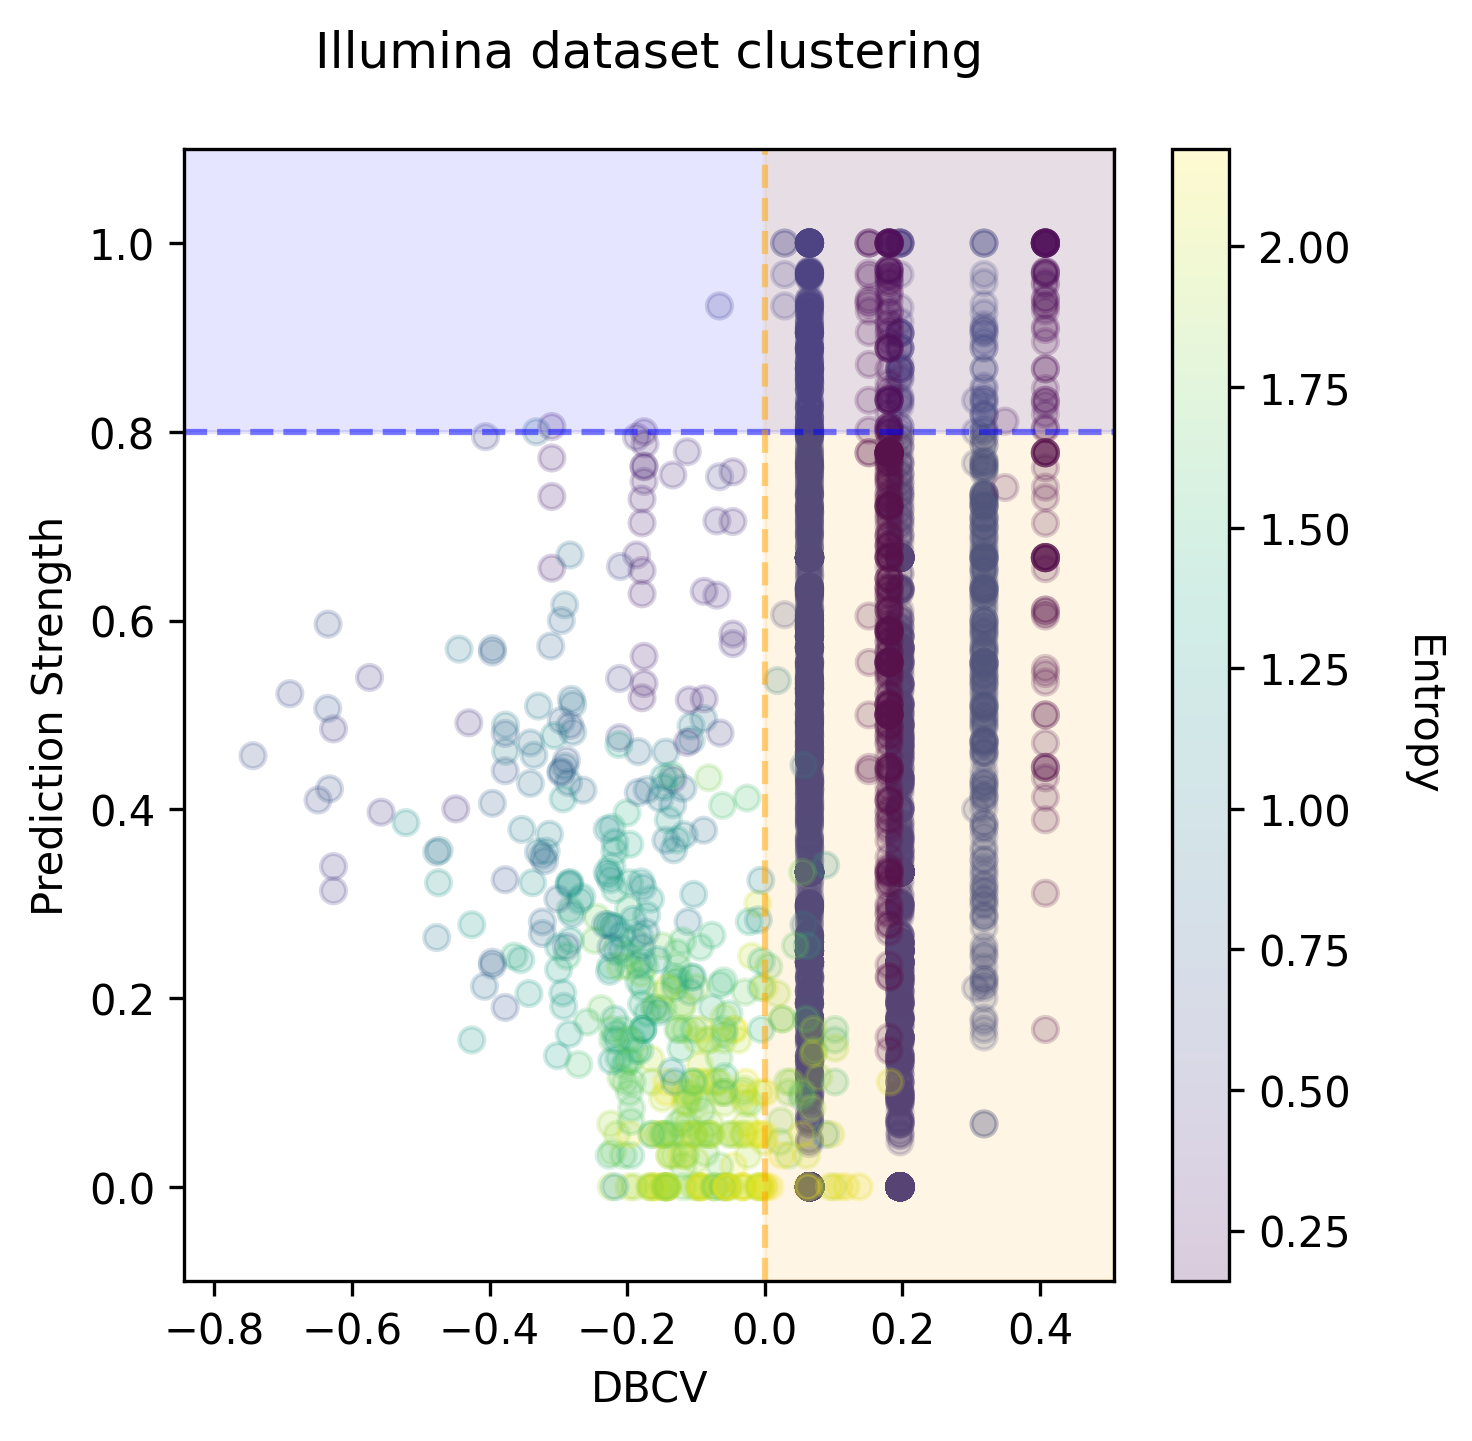

In [53]:
Illumina_df = clustering_results_df_.query('dataset == "Illumina"')

plot_clustering_scatter(Illumina_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Illumina dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

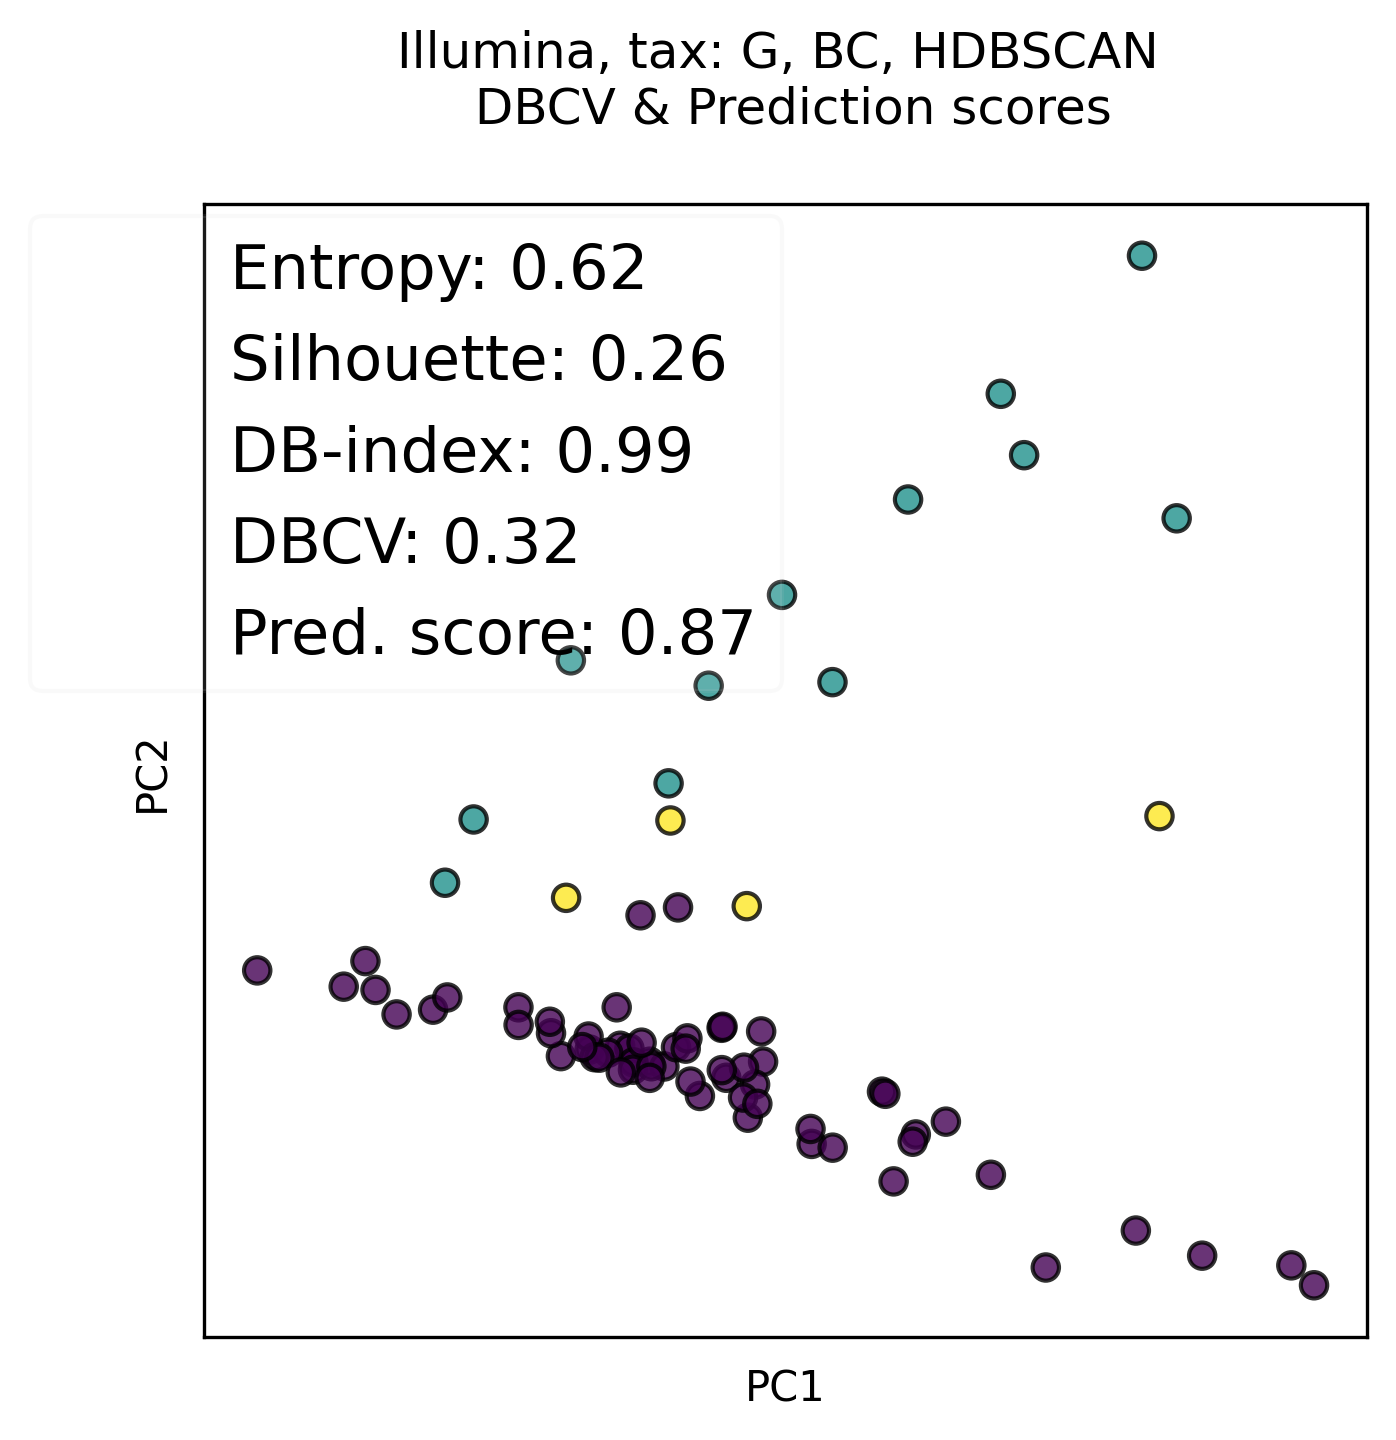

In [54]:
selection_mask_Illumina = (Illumina_df['dbcv'] > DBCV_THRESHOLD) * (Illumina_df['ps'] > PS_THRESHOLD)
df_selected = Illumina_df[selection_mask_Illumina]

# idx = (df_selected['ps'] + df_selected['dbcv']).idxmax()
idx = (df_selected['entropy']).idxmax()

# for idx in df_selected.index:

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Illumina_g'][:,:2][df_mask]

entropy, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(entropy))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. score: {:.2f}'.format(ps))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.57), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

# plt.setp(legend.get_bbox_patch(), boxstyle='round', alpha=0.5)
# legend.get_bbox_patch().set_boxstyle('round,pad=0.2')
# legend.get_bbox_patch().set_transform(plt.gcf().transFigure)
# legend.get_bbox_patch().set_bounds(0.4, 0.5, 0.2, 0.2)


# frame = legend.get_frame()
# # frame.set_height(0.5)
# # frame.set_width(0.1)

# frame.set_bounds(1,1,10,10)

plt.title(f'Illumina, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

#     break

In [57]:
df_selected['cl_method'].value_counts()

HDBSCAN               356
SpectralClustering      4
KMedoids                1
Name: cl_method, dtype: int64

## Pyroseq

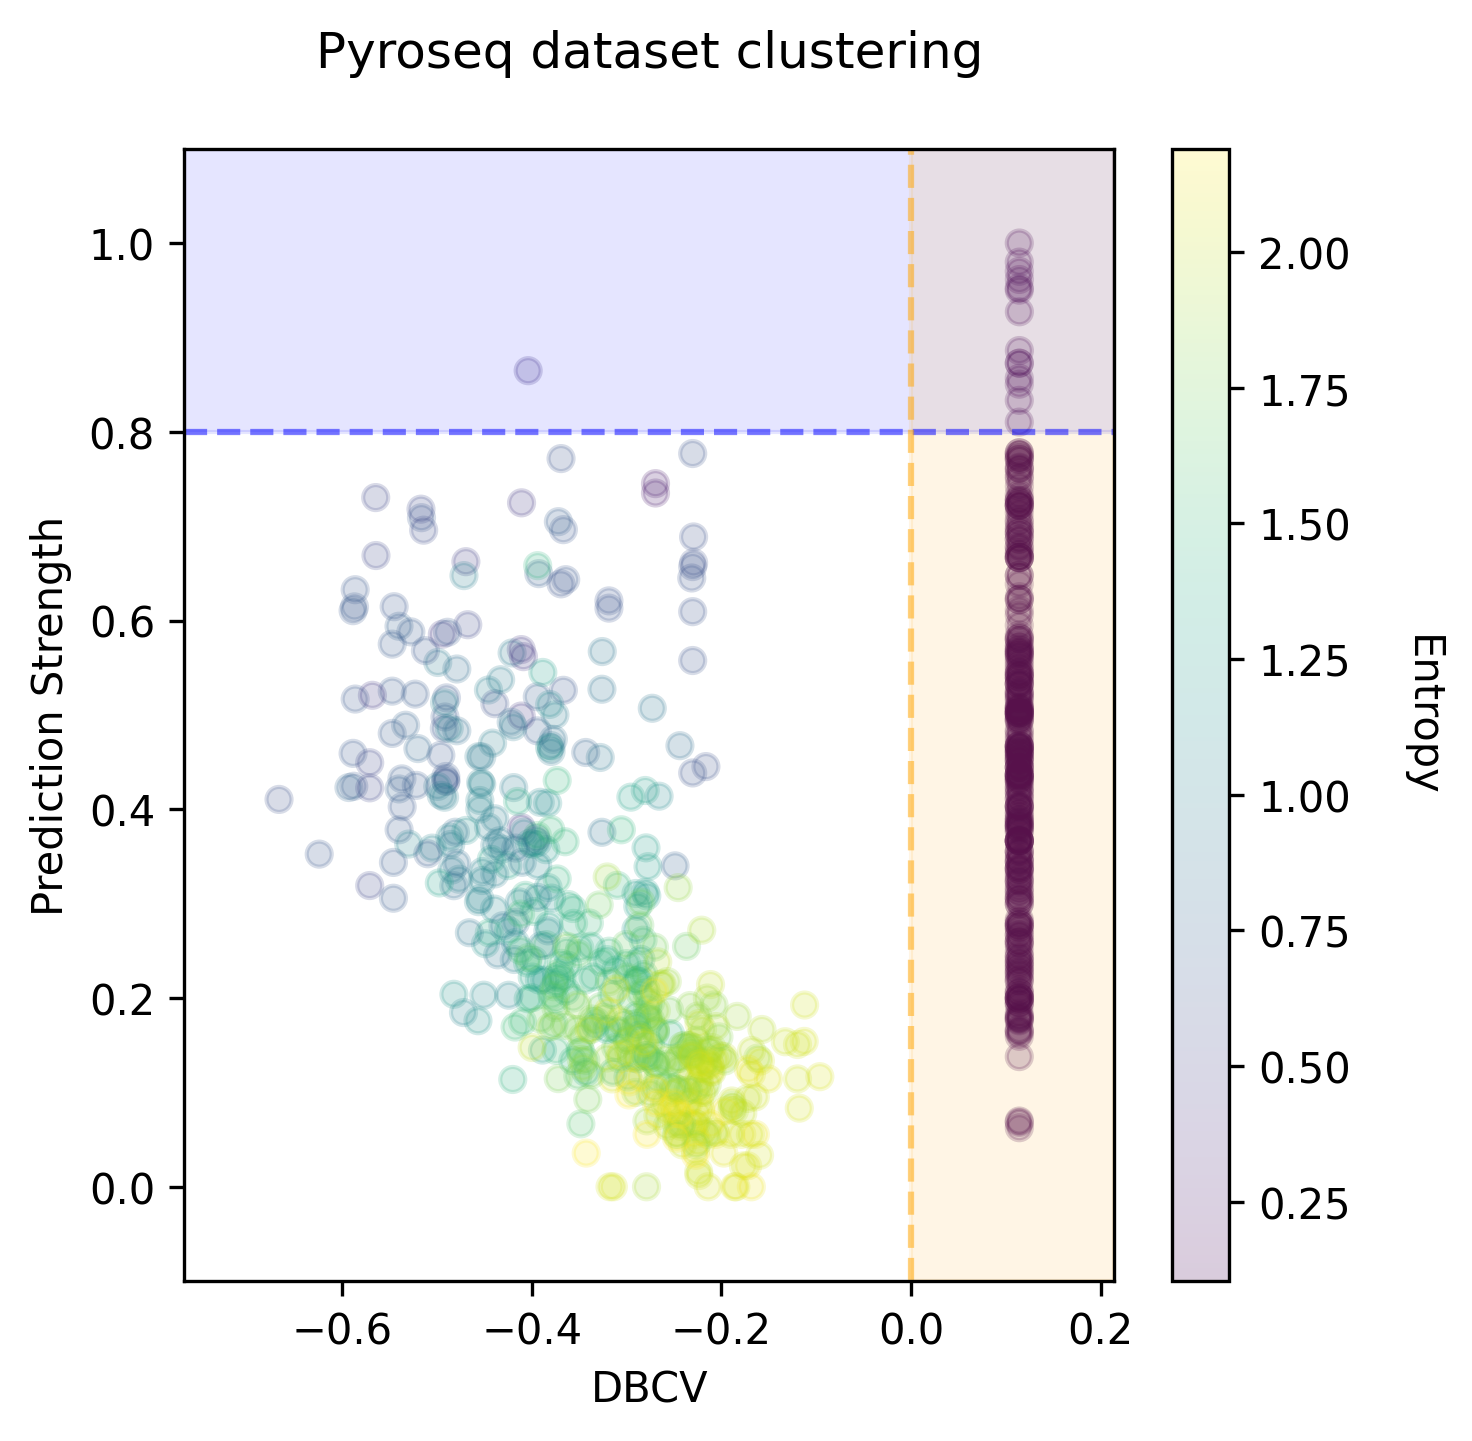

In [51]:
Pyroseq_df_ps = clustering_results_df_.query('dataset == "Pyroseq"')

plot_clustering_scatter(Pyroseq_df_ps, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Pyroseq dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

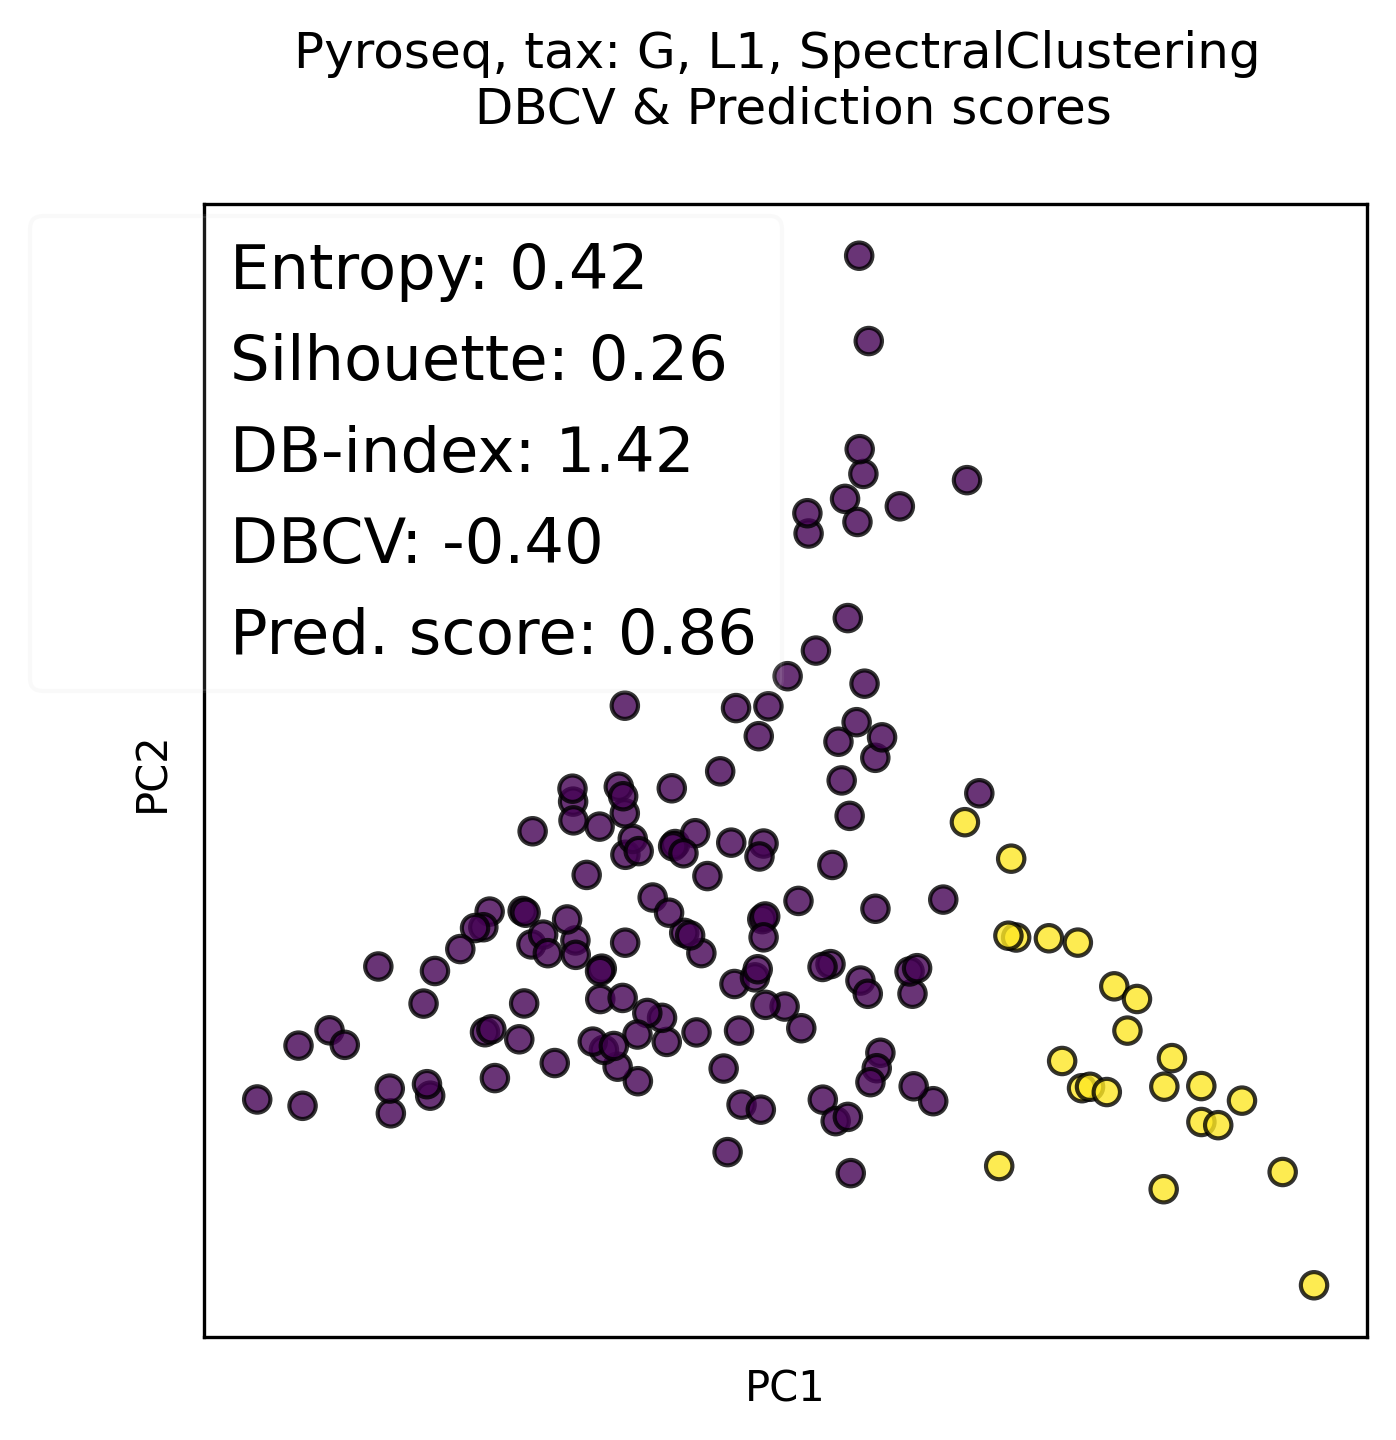

In [52]:
df_selected = Pyroseq_df_ps[(Pyroseq_df_ps['ps'] > PS_THRESHOLD)]

idx = df_selected['entropy'].idxmax()

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Pyroseq_g'][:,:2][df_mask]

entropy, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(entropy))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. score: {:.2f}'.format(ps))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.57), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

# plt.setp(legend.get_bbox_patch(), boxstyle='round', alpha=0.5)
# legend.get_bbox_patch().set_boxstyle('round,pad=0.2')
# legend.get_bbox_patch().set_transform(plt.gcf().transFigure)
# legend.get_bbox_patch().set_bounds(0.4, 0.5, 0.2, 0.2)


# frame = legend.get_frame()
# # frame.set_height(0.5)
# # frame.set_width(0.1)

# frame.set_bounds(1,1,10,10)
plt.title(f'Pyroseq, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()